# Init

In [1]:

import os
import pickle
import pandas as pd
# from postProcessingFunctions import processOutputs, replaceValueInFile, parallelizeFunction, genExtList
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gumbel_r, gumbel_l
from scipy.stats import genextreme

import re

import numpy as np

from IPython.display import display, Markdown

import moorpy as mp
import copy

from moorpy_functions import genMoorpySys2


In [2]:
resultsFol = r'..\results'
dataFol = r'..\data'

yamlFile = os.path.join(dataFol, "P200_C142_L1430_clump40.yaml")
sumDf_path = os.path.join(resultsFol, r"P200_C142_L1430_clump40_extreme.parquet")

anchorExtEventsDf_path = os.path.join(resultsFol, r"P200_C142_L1430_clump40_extreme_anchorExtremeEvents.parquet")
anchorExtStatsDf_path = os.path.join(resultsFol, r"P200_C142_L1430_clump40_extreme_anchorExtremeStats.parquet")
sumDf = pd.read_parquet(sumDf_path)
anchorExtEventsDf = pd.read_parquet(anchorExtEventsDf_path)
anchorExtStatsDf = pd.read_parquet(anchorExtStatsDf_path)
# ext_envCond = pd.read_excel(os.path.join(dataFol, r"envCond.xlsx"), index_col=0)

# anchorExtEventsDf = anchorExtEventsDf.droplevel(level=1)
# anchorExtStatsDf = anchorExtStatsDf.droplevel(level=1)

bodyYaml = os.path.join(dataFol, r"15MW_bdy.yaml")

1621105.381829551

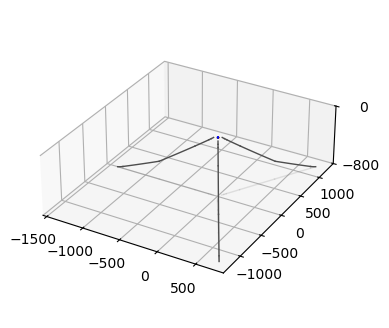

In [3]:

ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.plot()


ms.lineList[0].TA
# ms.lineList[0].TB

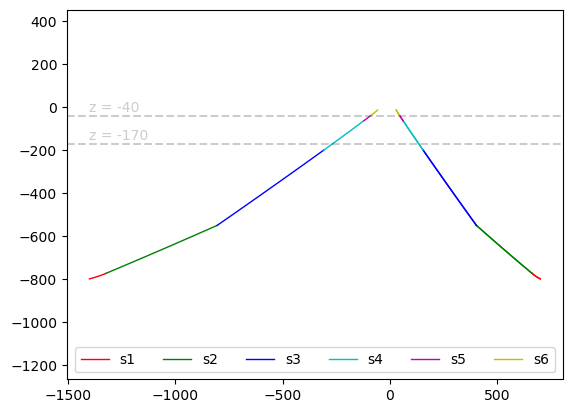

In [4]:

ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
fig, ax = plt.subplots(1, 1,)
ms.plot2d(ax = ax)
lines = ax.get_lines()

colGroups = {'s1' : ([1, 7, 13], 'r'),
             's2' : ([2, 8, 14], 'g'),
             's3' : ([3, 9, 15], 'b'),
             's4' : ([4, 10, 16], 'c'),
             's5' : ([5, 11, 17], 'm'),
             's6' : ([6, 12, 18], 'y')}

legendList = []
for id in colGroups:
    for ind, i in enumerate(colGroups[id][0]):
        lines[i-1].set_color(colGroups[id][1])
        if ind == 0:
            legendList.append(lines[i-1])
        
        

# ax.set_ylim(-900,)
ax.axhline(-170, color = 'k', linestyle = '--', alpha = 0.2)
ax.text(-1400, -170+20, 'z = -170', color = 'k', alpha = 0.2)

ax.axhline(-40, color = 'k', linestyle = '--', alpha = 0.2)
ax.text(-1400, -40+20, 'z = -40', color = 'k', alpha = 0.2)

#put legend outside the plot in
ax.legend(legendList, colGroups.keys(), loc = 'lower center', bbox_to_anchor=(0.5, 0), ncol = 6)


In [5]:
def extractInfoFromIndex(index):

    #Extract information about the run from the index
    match = re.match(r"Run_P(\d+)_C(\d+)_.*_([a-z,A-Z,\d,.,_]+)_(\d+)_S(\d+).*.outb", index)

    if match:
        return match.groups()
    else:
        raise ValueError(f"Index {index} does not match the pattern")




def checkDataFrame(df):
    if df.isna().any().any():
        raise ValueError("DataFrame contains NA values")
    

def displayDf(df, nCols = 5):

    for i in range(0, len(df.columns), nCols):
        display(Markdown(df.iloc[:, i:i+nCols].to_markdown()))



def checkTensionExtremes(sumDf, valHeader, valType='max', head=None):
    """
    Function which determines the critical tension to be considered 
    """
    
    # Select the max values from the DataFrame based on valType and valHeader
    df = sumDf.xs(valType, axis=1, level=1).loc[:, valHeader].copy()
     
    # Find the column with the max or min tension value for each row based on valType
    if valType == 'max':
        df['maxTenCol'] = df.idxmax(axis=1)
        df['maxTen'] = df.iloc[:,:-1].max(axis=1) # Exclude the last column which contains the name of the column with the max value
    elif valType == 'min':
        df['minTenCol'] = df.idxmin(axis=1)
        df['minTen'] = df.iloc[:,:-1].min(axis=1)
    else:
        raise ValueError("valType must be either 'max' or 'min'")
    
    # Add additional columns from the original DataFrame
    df['cond_head'] = sumDf['cond_head']
    df['seed'] = sumDf['seed']
    df['heading'] = sumDf['heading']
    df['polyDia'] = sumDf['polyDia']
    

    # Filter by the specified heading
    if head is not None:
        df = df[df['heading'] == head]

    if valType == 'max':
        val = df['maxTen'].max()
        loc = df['maxTen'].idxmax()
    elif valType == 'min':
        val = df['minTen'].min()
        loc = df['minTen'].idxmin()

    # Print unique maximum tension columns
    print(f'{valType} tensions occurring in {df[f"{valType}TenCol"].unique()} and val is {val} @ {loc}')
    
    return df



# ---------- Some Moorpy functions ----------

# def printMsStats(mpySys, topChainLineIndex, topChainLineIndex, waterDepth):

#     print('Body location')
#     print(f'{mpySys.bodyList[0].r6}')

#     topTenList = []

    
        
#         for ind, (lineId, pointId) in enumerate(zip(topChainLineIndex, bottomChainTopPointIndex)):

#             print(f'Line {ind + 1}')
#             if moorpyVersion == '1.1.0' :
#                 print(f'Top tension : {mpySys.lineList[lineId-1].getTension(s = 1)/1000:.2f} kN') #tension at the top of the chain - end B
#                 print(f'Anchor tension : {mpySys.lineList[lineId-1].getTension(s = 0)/1000:.2f} kN') #tension at the anchor - end A
#             else:
#                 print(f'Top tension : {mpySys.lineList[lineId-1].getLineTens()[-1]/1000:.2f} kN')
#                 print(f'Anchor tension : {mpySys.lineList[lineId-1].getLineTens()[0]/1000:.2f} kN')
#             print(f'z locaton of transition top of btm chain : {mpySys.pointList[pointId].r[2] + waterDepth:.2f} m')
#             topTenList.append(mpySys.lineList[lineId-1].getTension(s = 1))

#     else :

#         print('Body location')
#         print(f'{mpySys.bodyList[0].r6}')

#         print('Line 1')
#         print(f'Top tension : {mpySys.lineList[2].getLineTens()[-1]/1000:.2f} kN') #tension at the top of the chain - end B
#         print(f'Anchor tension : {mpySys.lineList[0].getLineTens()[0]/1000:.2f} kN') #tension at the anchor - end A
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[1].r[2] + 800:.2f} m')

#         print('Line 2')
#         print(f'Top tension : {mpySys.lineList[5].getLineTens()[-1]/1000:.2f} kN') 
#         print(f'Anchor tension : {mpySys.lineList[3].getLineTens()[0]/1000:.2f} kN')
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[5].r[2] + 800:.2f} m')

#         print('Line 3')
#         print(f'Top tension : {mpySys.lineList[8].getLineTens()[-1]/1000:.2f} kN') 
#         print(f'Anchor tension : {mpySys.lineList[6].getLineTens()[0]/1000:.2f} kN') 
#         print(f'z locaton of transition top of btm chain : {mpySys.pointList[9].r[2] + 800:.2f} m')
#         preTension = np.mean([mpySys.lineList[2].getLineTens()[-1], mpySys.lineList[5].getLineTens()[-1], mpySys.lineList[8].getLineTens()[-1]])
    
#     preTension = np.mean(topTenList)
#     print(f'Average top tension : {preTension/1000:.2f} kN')

#     return preTension



def getLineTensions(mpySys, lineIndexList, end = 'fA'):

    '''
    lineIndexList : list of line indices - the index as seen in the moorDyn file. The index starts at 1
    s = 0 for end A and s = -1 for end B
    '''

    tensionList = []
    for ind, lineId in enumerate(lineIndexList):


        ten = np.linalg.norm(getattr(mpySys.lineList[lineId-1], end))
        
        
        # ten = mpySys.lineList[lineId-1].getTension(s = s)
     
        # else :
        #     ten = mpySys.lineList[lineId-1].getLineTens()

        #     if s== 0 :
        #         ten = ten[0]
        #     elif s == 1 :
        #         ten = ten[-1]
        #     else :
        #         raise ValueError('s must be 0 or 1 for moorpy version < 1.1.0')

        # ten = mpySys.lineList[lineId-1].getTension(s = s)
        print(f'Line {ind + 1} : {ten/1000:.2f} kN')
        tensionList.append(ten)

    return tensionList



In [13]:
ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type

In [19]:
getLineTensions(ms, lineIndexList = [0,1, 3, 4,5,6,7,8,9], end = 'fA')

Line 1 : 1973.10 kN
Line 2 : 1621.11 kN
Line 3 : 1915.71 kN
Line 4 : 1939.74 kN
Line 5 : 1965.84 kN
Line 6 : 1973.10 kN
Line 7 : 1620.92 kN
Line 8 : 1707.30 kN
Line 9 : 1915.72 kN


[1973096.401492991,
 1621105.381829551,
 1915709.145856917,
 1939741.7124153378,
 1965841.2590690556,
 1973096.6493285235,
 1620917.1897000305,
 1707303.9711245305,
 1915716.4566899198]

In [6]:
#extract information form the index columns
for df in [sumDf, anchorExtStatsDf, anchorExtEventsDf]:

    if len(df.index[0]) != 1:
        index = df.index.get_level_values(0)
    else :
        index = df.index 
    df[['polyDia', 'chainDia', 'cond', 'heading', 'seed']] = index.map(extractInfoFromIndex).to_list()

    #additional modifications
    df['polyDia']        = df['polyDia'].astype(float)/1000 #convert to meters
    df['chainDia']       = df['chainDia'].astype(float)/1000 #convert to meters
    df['seed']           = df['seed'].str.replace(r'(\d+)', lambda x: x.group(0).zfill(2), regex=True) #change S1 to S01
    df['cond_head']      = df['cond'] + '_' + df['heading']
    df['heading']        = df['heading'].astype(float)

    #check for NA values
    checkDataFrame(df)

# Wave elevation

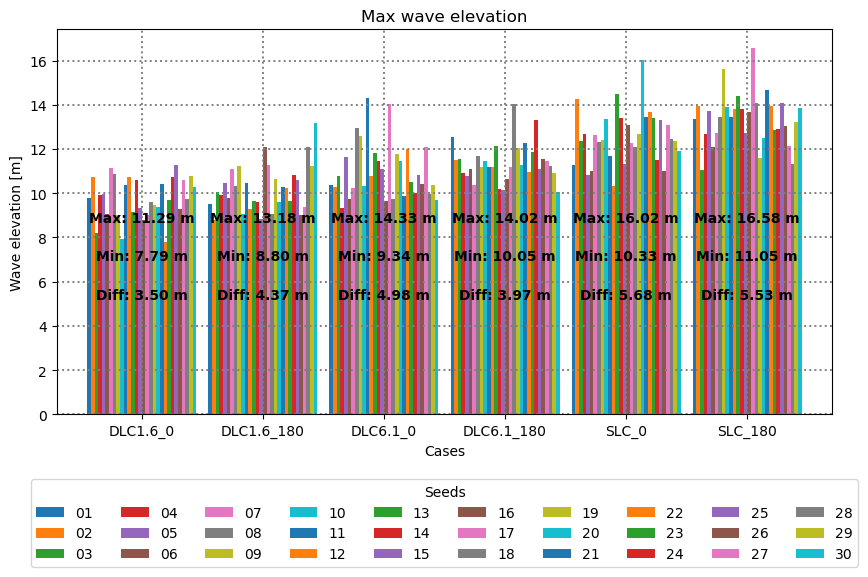

Max wave elevation [m]


| cond_head   |       01 |       02 |       03 |       04 |       05 |       06 |
|:------------|---------:|---------:|---------:|---------:|---------:|---------:|
| DLC1.6_0    |  9.80585 | 10.7538  |  8.18614 |  9.92399 |  9.96938 |  9.04955 |
| DLC1.6_180  |  9.50249 |  8.80403 | 10.0651  |  9.93606 | 10.4612  |  9.798   |
| DLC6.1_0    | 10.3822  | 10.2724  | 10.8002  |  9.34494 | 11.6351  |  9.7535  |
| DLC6.1_180  | 12.5225  | 11.4987  | 11.5516  | 10.927   | 10.759   | 11.1162  |
| SLC_0       | 11.2853  | 14.2734  | 12.3645  | 12.6866  | 10.8269  | 11.0135  |
| SLC_180     | 13.3456  | 13.9246  | 11.0521  | 12.665   | 13.7292  | 12.105   |

| cond_head   |      07 |      08 |       09 |       10 |      11 |       12 |
|:------------|--------:|--------:|---------:|---------:|--------:|---------:|
| DLC1.6_0    | 11.1255 | 10.8716 |  9.03576 |  7.91209 | 10.3914 | 10.7477  |
| DLC1.6_180  | 11.0996 | 10.3205 | 11.2162  |  9.07238 | 10.478  |  9.26512 |
| DLC6.1_0    | 10.2482 | 12.9402 | 12.5841  | 10.3288  | 14.328  | 10.7815  |
| DLC6.1_180  | 10.3536 | 11.703  | 11.2073  | 11.4552  | 11.1941 | 11.1692  |
| SLC_0       | 12.6463 | 12.3127 | 12.4019  | 13.3601  | 11.6877 | 10.3342  |
| SLC_180     | 12.709  | 13.451  | 15.6093  | 13.919   | 13.4308 | 13.7918  |

| cond_head   |       13 |       14 |       15 |       16 |       17 |       18 |
|:------------|---------:|---------:|---------:|---------:|---------:|---------:|
| DLC1.6_0    |  9.13058 | 10.6161  |  9.34561 |  8.80366 |  9.03151 |  9.59225 |
| DLC1.6_180  |  9.62842 |  9.62556 |  8.85767 | 12.0954  | 11.2717  |  9.07368 |
| DLC6.1_0    | 11.8416  | 11.4776  | 11.1125  |  9.64906 | 14.0346  |  9.72474 |
| DLC6.1_180  | 12.1499  | 10.2115  | 10.1426  | 10.6468  | 11.193   | 14.0228  |
| SLC_0       | 14.4772  | 13.4217  | 11.3398  | 13.1019  | 12.255   | 12.1128  |
| SLC_180     | 14.4054  | 13.817   | 12.7126  | 13.6575  | 16.5826  | 14.0943  |

| cond_head   |       19 |       20 |       21 |       22 |       23 |      24 |
|:------------|---------:|---------:|---------:|---------:|---------:|--------:|
| DLC1.6_0    |  9.44651 |  9.36828 | 10.4285  |  7.79097 |  9.70341 | 10.7492 |
| DLC1.6_180  | 10.6573  |  9.58398 | 10.2695  | 10.2455  |  9.66288 | 10.8466 |
| DLC6.1_0    | 11.7971  | 11.4629  |  9.85352 | 12.0111  | 10.5296  | 10.0317 |
| DLC6.1_180  | 12.0532  | 11.2796  | 12.2917  | 10.9827  | 11.8649  | 13.3258 |
| SLC_0       | 12.6673  | 16.017   | 13.4516  | 13.6658  | 13.4093  | 11.5228 |
| SLC_180     | 11.6126  | 12.5156  | 14.6825  | 13.9253  | 12.8405  | 12.9142 |

| cond_head   |      25 |       26 |       27 |       28 |      29 |       30 |
|:------------|--------:|---------:|---------:|---------:|--------:|---------:|
| DLC1.6_0    | 11.2865 |  9.28007 | 10.6078  |  9.75376 | 10.7742 | 10.2756  |
| DLC1.6_180  | 10.5868 |  9.02341 |  9.36088 | 12.0784  | 11.2548 | 13.1765  |
| DLC6.1_0    | 10.8303 | 10.4019  | 12.0812  |  9.95105 | 10.3821 |  9.69055 |
| DLC6.1_180  | 11.1077 | 11.5421  | 11.442   | 11.2257  | 10.9025 | 10.0501  |
| SLC_0       | 13.3155 | 11.0111  | 13.0822  | 12.4363  | 12.3523 | 11.9202  |
| SLC_180     | 14.0916 | 13.0276  | 12.1536  | 11.3431  | 13.2316 | 13.8695  |

| cond_head   |      min |     max |
|:------------|---------:|--------:|
| DLC1.6_0    |  7.79097 | 11.2865 |
| DLC1.6_180  |  8.80403 | 13.1765 |
| DLC6.1_0    |  9.34494 | 14.328  |
| DLC6.1_180  | 10.0501  | 14.0228 |
| SLC_0       | 10.3342  | 16.017  |
| SLC_180     | 11.0521  | 16.5826 |

In [7]:
valHeader = ['Wave1Elev']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']


pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='Wave1Elev')


# pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
# pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
# pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Cases')
plt.ylabel('Wave elevation [m]')
plt.xticks(rotation=0)
plt.title('Max wave elevation')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Max wave elevation [m]')
displayDf(pivot_df, nCols = 6)

# Caculate pretensions

## Installed

None
Top tensions are[2049.885871042141, 2046.4083795358654, 2049.8858658452527] kN
Average top tension is 2048.7267054744198 kN
Body postion is [ 4.21225535e-01 -8.64669948e-10 -8.97448361e-01 -3.46561715e-12
 -2.47712427e-02  8.67525057e-11]


(<Figure size 600x400 with 1 Axes>, <Axes: >)

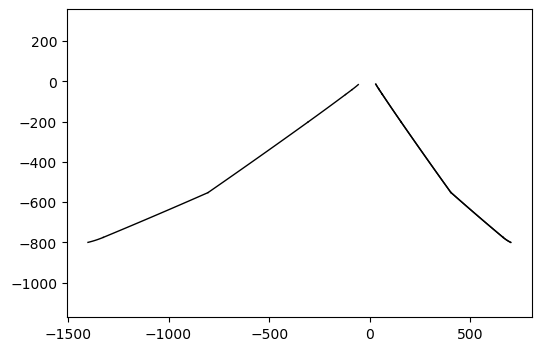

In [8]:
ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.bodyList[0].type = 0

conv = ms.solveEquilibrium3(tol=0.0001)
print(conv)

#Top tensions
topTen = [np.linalg.norm(ms.lineList[5].fB)/1000, np.linalg.norm(ms.lineList[11].fB)/1000, np.linalg.norm(ms.lineList[17].fB)/1000]

print(f'Top tensions are{topTen} kN')

print(f'Average top tension is {np.mean(topTen)} kN', )

print(f'Body postion is {ms.bodyList[0].r6}', )

ms.plot2d(color = 'k')

## Installation

Top tensions are[1080.3329318744006, 1078.2929321124047, 1080.3328445521786] kN
Average top tension is 1079.652902846328 kN
Body postion is [ 4.78959511e-01  6.82133376e-11 -4.84016654e-01 -3.84432159e-14
 -2.56808559e-02 -2.46008826e-15]


(<Figure size 600x400 with 1 Axes>, <Axes: >)

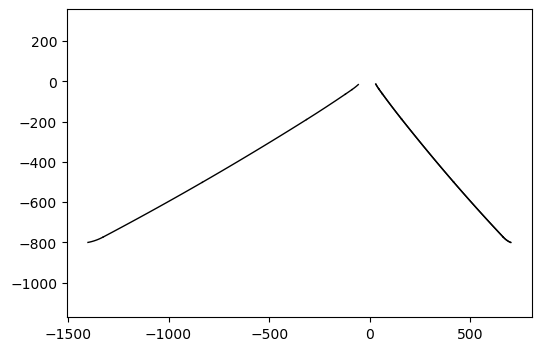

In [9]:


ms = genMoorpySys2(yamlFile, bodyYaml) #body type returned is -1 --> coupled type
ms.bodyList[0].type = 0

for id in [3, 10, 17]: #set clump weights to zero
    ms.pointList[id-1].m = 0

conv = ms.solveEquilibrium3(tol=0.0001)

#Top tensions
topTen = [np.linalg.norm(ms.lineList[5].fB)/1000, np.linalg.norm(ms.lineList[11].fB)/1000, np.linalg.norm(ms.lineList[17].fB)/1000]

print(f'Top tensions are{topTen} kN')

print(f'Average top tension is {np.mean(topTen)} kN', )
print(f'Body postion is {ms.bodyList[0].r6}', )

ms.plot2d(color = 'k')

# Line properties

In [10]:
if sumDf['polyDia'].nunique() != 1 or sumDf['chainDia'].nunique() != 1:
    raise ValueError('Multiple MBLs for the same diameter')

polyDia = sumDf['polyDia'].unique()[0]
chainDia = sumDf['chainDia'].unique()[0]

linePropsDf = pd.read_csv(os.path.join(dataFol,r'lineProps.csv')) #get the line properties to calcualte the safety factor
polyDat = (linePropsDf['lineType'] == 'polyester') & (linePropsDf['dt_mg'] == 0.05) & (linePropsDf['dt_corr'] == 0) & (linePropsDf['nomDia'] == polyDia)
botChainDat = (linePropsDf['lineType'] == 'sl_chain') & (linePropsDf['dt_mg'] == 0.05) & (linePropsDf['dt_corr'] == 0.01) & (linePropsDf['nomDia'] == chainDia)
topChainDat = (linePropsDf['lineType'] == 'sl_chain') & (linePropsDf['dt_mg'] == 0.1) & (linePropsDf['dt_corr'] == 0.01) & (linePropsDf['nomDia'] == chainDia)

lineDf = linePropsDf.loc[polyDat | botChainDat | topChainDat, :]


polyMbl = lineDf.loc[polyDat, 'mbl'].values[0]

displayDf(lineDf, 5)




|     | lineType   |   nomDia |   dt_mg |   dt_corr |   massDensity |
|----:|:-----------|---------:|--------:|----------:|--------------:|
|  29 | polyester  |    0.2   |    0.05 |      0    |       79.1926 |
| 105 | sl_chain   |    0.142 |    0.05 |      0.01 |      483.202  |
| 108 | sl_chain   |    0.142 |    0.1  |      0.01 |      604.75   |

|     |   subWeight |   volEqDia |         mbl | EA                                    |   transDrag_eqDia |
|----:|------------:|-----------:|------------:|:--------------------------------------|------------------:|
|  29 |     184.861 |   0.273796 | 1.232e+07   | [172480000.00000003, (11.615, 0.396)] |           1.75313 |
| 105 |    3617.75  |   0.377003 | 1.56646e+07 | 1725925872.7815998                    |           1.54057 |
| 108 |    3887.72  |   0.508853 | 1.56646e+07 | 1725925872.7815998                    |           1.61304 |

|     |   longDrag_eqDia |   transAddedMass_eqDia |   longAddedMass_eqDia |
|----:|-----------------:|-----------------------:|----------------------:|
|  29 |         0        |                1.32063 |              0.180086 |
| 105 |         0.73819  |                1.33501 |              0.667507 |
| 108 |         0.772915 |                1.46357 |              0.731783 |

# Assumptions


- Line slackness check
  - SLC condition is considered for strength check of lines. Line slackness check fails for SLC condition -> pretension will have to be very high and higher line diameter will be required if this has to be satisfied.
- Only aligned WWC (wind wave current) has been considered - both along the line (0 deg. heading) and between the line (180 deg) condition is considered.
- Current modelling
  - Current loading on the platform accounted by applying a constant force calculated based on the surface current velocity and quadratic drag coefficient of the platform
  - Current loading on the mooring line is considered by considering a linear profile of the current velocity along the water depth 
- Wave loads acting on the mooring line is not considered.


# Mean line tension at fairlead

* Environment : WWC aligned, 0 deg heading
* Line considered : Line 2

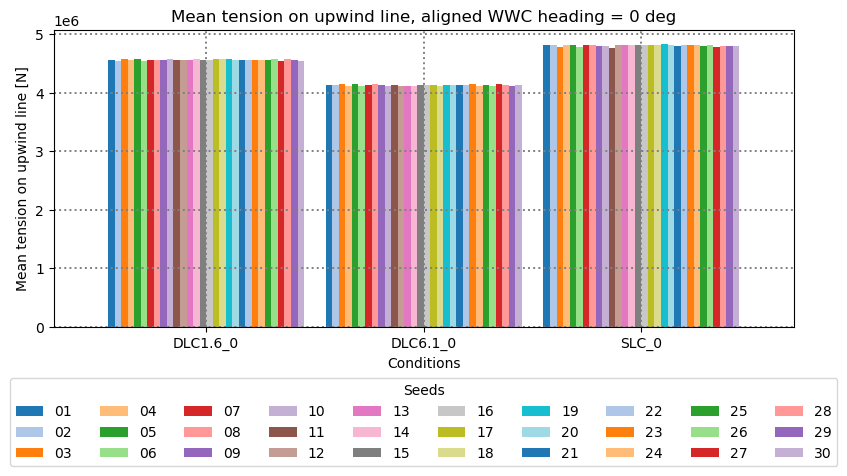

Mean tensions [N] on upwind line, aligned WWC heading = 0 deg


| cond_head   |          01 |          02 |          03 |          04 |          05 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.55303e+06 | 4.53518e+06 | 4.57819e+06 | 4.55274e+06 | 4.56974e+06 |
| DLC6.1_0    | 4.13316e+06 | 4.12662e+06 | 4.1417e+06  | 4.10863e+06 | 4.14124e+06 |
| SLC_0       | 4.82197e+06 | 4.80797e+06 | 4.77802e+06 | 4.80654e+06 | 4.80694e+06 |

| cond_head   |          06 |          07 |          08 |          09 |          10 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.54343e+06 | 4.55979e+06 | 4.56164e+06 | 4.56438e+06 | 4.5689e+06  |
| DLC6.1_0    | 4.1101e+06  | 4.12924e+06 | 4.14564e+06 | 4.12927e+06 | 4.11833e+06 |
| SLC_0       | 4.78384e+06 | 4.80712e+06 | 4.82128e+06 | 4.7969e+06  | 4.80525e+06 |

| cond_head   |          11 |          12 |          13 |          14 |          15 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.56375e+06 | 4.56138e+06 | 4.5616e+06  | 4.57868e+06 | 4.55736e+06 |
| DLC6.1_0    | 4.13568e+06 | 4.11903e+06 | 4.11693e+06 | 4.12093e+06 | 4.13014e+06 |
| SLC_0       | 4.76725e+06 | 4.80855e+06 | 4.80568e+06 | 4.80663e+06 | 4.81505e+06 |

| cond_head   |          16 |          17 |          18 |          19 |          20 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.55821e+06 | 4.5704e+06  | 4.57352e+06 | 4.56851e+06 | 4.56269e+06 |
| DLC6.1_0    | 4.13563e+06 | 4.13351e+06 | 4.11285e+06 | 4.12557e+06 | 4.12575e+06 |
| SLC_0       | 4.818e+06   | 4.80907e+06 | 4.81847e+06 | 4.83654e+06 | 4.81716e+06 |

| cond_head   |          21 |          22 |          23 |          24 |          25 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.56592e+06 | 4.56496e+06 | 4.55467e+06 | 4.55517e+06 | 4.56242e+06 |
| DLC6.1_0    | 4.12241e+06 | 4.12626e+06 | 4.14227e+06 | 4.11223e+06 | 4.13496e+06 |
| SLC_0       | 4.80189e+06 | 4.81543e+06 | 4.80566e+06 | 4.80636e+06 | 4.79772e+06 |

| cond_head   |          26 |          27 |          28 |          29 |          30 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 4.5687e+06  | 4.54844e+06 | 4.57047e+06 | 4.56014e+06 | 4.54704e+06 |
| DLC6.1_0    | 4.11464e+06 | 4.14249e+06 | 4.13155e+06 | 4.11921e+06 | 4.12563e+06 |
| SLC_0       | 4.81523e+06 | 4.78153e+06 | 4.80107e+06 | 4.79992e+06 | 4.80203e+06 |

MeanTension/MBL % = 36.51


In [11]:
valHeader = ['FAIRTEN12']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']

head = 0  #heading to be analyzed
maxPd = maxPd[maxPd['heading'] == head]


pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df.plot(kind='bar', figsize=(9, 5), width=0.9, color = plt.cm.tab20.colors)

plt.xlabel('Conditions')
# plt.ylabel('FAIRTEN6_max [N]')
plt.ylabel('Mean tension on upwind line [N]')
plt.xticks(rotation=0)
plt.title(f'Mean tension on upwind line, aligned WWC heading = {head} deg')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.tight_layout()
plt.show()

print(f"Mean tensions [N] on upwind line, aligned WWC heading = {head} deg")


displayDf(pivot_df, nCols = 5)

print(f'MeanTension/MBL % = {np.mean(pivot_df.values)/polyMbl * 100:.2f}')


# Comparison of mean of tension from dynamic simulations and value used for stiffness calculation

In [12]:
valHeader = [col[0] for col in sumDf.columns if col[1] == 'mean' and ('FAIR' in col[0] or 'ANCH' in col[0]) and ('HORZ' not in col[0])]

valType   = 'mean'
#
nSeg = meanPd.shape[1]//2


moorpyTenPd = pd.read_parquet(os.path.splitext(sumDf_path)[0] + '_meanLineTensions.parquet')
# moorpyTenPd.index = moorpyTenPd.index.str.replace('Run_P200','Run_Moordyn_P200')
moorpyTenPd.index = moorpyTenPd.index + '.outb'

diff = (meanPd  - moorpyTenPd)/moorpyTenPd*100

print(f'Max difference between Moorpy and OpenFAST tensions {diff.abs().max().max():.2f}% at {diff.abs().idxmax().max()}' )



NameError: name 'meanPd' is not defined

# Max line tension at fairlead

* Environment : WWC aligned, 0 deg heading
* Line considered : Line 2

## Polyester

In [ ]:
valHeader = [f'{ten}{ind}' for ind in range(7,13) for ten in ['ANCHTEN', 'FAIRTEN']]
valType   = 'max'
head = 0
maxPd = checkTensionExtremes(sumDf, valHeader, valType, head)
maxPd


max tensions occurring in ['FAIRTEN12'] and val is 7482550.0 @ Run_P200_C142_L1430_clump40_SLC_0_S17.outb


,ANCHTEN7,FAIRTEN7,ANCHTEN8,FAIRTEN8,ANCHTEN9,FAIRTEN9,ANCHTEN10,FAIRTEN10,ANCHTEN11,FAIRTEN11,ANCHTEN12,FAIRTEN12,maxTenCol,maxTen,cond_head,seed,heading,polyDia
Run_P200_C142_L1430_clump40_DLC1.6_0_S1.outb,5148544.5,5265301.0,5265275.0,5280489.5,5461248.0,5475674.0,5473725.5,5486772.5,5483849.0,5488875.5,5485019.5,5552057.5,FAIRTEN12,5552057.5,DLC1.6_0,01,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S10.outb,4991285.0,5107883.0,5107856.0,5123816.0,5307887.5,5325182.0,5323971.0,5340792.0,5339013.5,5345032.0,5342702.5,5417279.0,FAIRTEN12,5417279.0,DLC1.6_0,10,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S11.outb,5159191.0,5276253.5,5276244.0,5292386.5,5477200.0,5493837.5,5492473.0,5508277.0,5506159.5,5511868.5,5509066.0,5581383.0,FAIRTEN12,5581383.0,DLC1.6_0,11,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S12.outb,5395323.5,5511986.0,5511947.5,5525843.5,5700473.0,5712131.5,5709489.0,5719162.0,5715225.5,5719465.5,5714297.5,5778221.0,FAIRTEN12,5778221.0,DLC1.6_0,12,0.0,0.2
Run_P200_C142_L1430_clump40_DLC1.6_0_S13.outb,5216427.5,5333260.5,5333240.0,5348977.0,5532157.0,5548195.5,5546724.5,5562071.0,5559880.5,5565502.5,5562614.5,5634982.5,FAIRTEN12,5634982.5,DLC1.6_0,13,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Run_P200_C142_L1430_clump40_SLC_0_S5.outb,6493614.5,6610840.0,6610810.5,6625284.0,6800252.5,6812291.0,6809842.0,6820528.0,6816830.5,6821416.5,6816568.0,6882023.0,FAIRTEN12,6882023.0,SLC_0,05,0.0,0.2
Run_P200_C142_L1430_clump40_SLC_0_S6.outb,6428348.5,6545221.0,6545190.5,6559304.0,6732537.0,6743324.5,6740526.0,6749362.0,6745075.5,6749136.0,6743506.0,6808769.5,FAIRTEN12,6808769.5,SLC_0,06,0.0,0.2
Run_P200_C142_L1430_clump40_SLC_0_S7.outb,6306743.0,6422598.0,6422557.5,6436032.0,6606037.0,6615343.5,6612163.0,6623539.5,6620064.0,6624782.0,6620200.5,6686579.0,FAIRTEN12,6686579.0,SLC_0,07,0.0,0.2
Run_P200_C142_L1430_clump40_SLC_0_S8.outb,7050412.0,7168082.0,7168054.0,7181839.5,7353316.5,7362927.0,7359896.0,7367159.0,7362481.0,7366197.0,7360042.5,7419490.5,FAIRTEN12,7419490.5,SLC_0,08,0.0,0.2


In [ ]:
valHeader = ['FAIRTEN12']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['maxTenCol']  = maxPd.idxmax(axis = 1)
maxPd['maxTenVal']  = maxPd.iloc[:,:-1].max(axis = 1)
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']
maxPd['polyDia']    = sumDf['polyDia']


#only heading = 0 is of interest
head = 0  #heading to be analyzed
maxPd = maxPd[maxPd['heading'] == head]

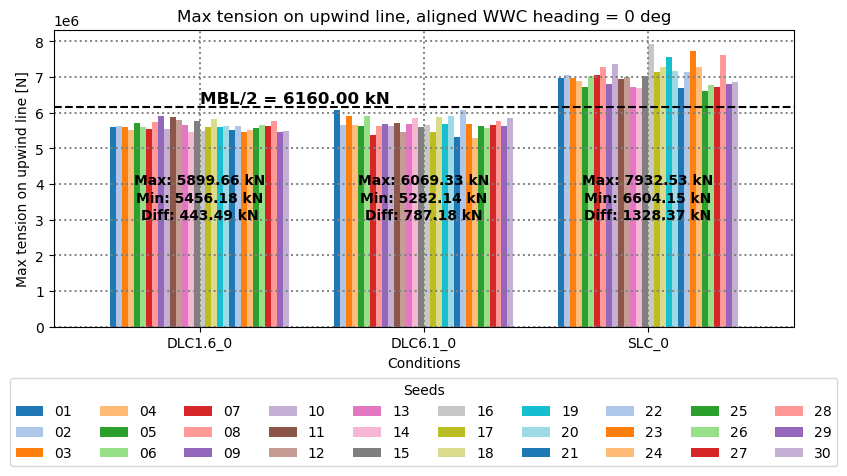

Max tensions [N] on upwind line, aligned WWC heading = 0 deg


| cond_head   |          01 |          02 |          03 |          04 |          05 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.59936e+06 | 5.61061e+06 | 5.59489e+06 | 5.50606e+06 | 5.70175e+06 |
| DLC6.1_0    | 6.06232e+06 | 5.65463e+06 | 5.89724e+06 | 5.66429e+06 | 5.63141e+06 |
| SLC_0       | 6.97378e+06 | 7.06021e+06 | 6.96259e+06 | 6.885e+06   | 6.71435e+06 |

| cond_head   |          06 |          07 |          08 |          09 |          10 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.60073e+06 | 5.54623e+06 | 5.73084e+06 | 5.89966e+06 | 5.53381e+06 |
| DLC6.1_0    | 5.9112e+06  | 5.35864e+06 | 5.6269e+06  | 5.68506e+06 | 5.62646e+06 |
| SLC_0       | 7.03847e+06 | 7.06626e+06 | 7.2899e+06  | 6.80034e+06 | 7.37313e+06 |

| cond_head   |          11 |          12 |          13 |          14 |          15 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.86814e+06 | 5.79611e+06 | 5.65089e+06 | 5.45789e+06 | 5.75888e+06 |
| DLC6.1_0    | 5.72111e+06 | 5.44278e+06 | 5.69154e+06 | 5.83715e+06 | 5.59354e+06 |
| SLC_0       | 6.93978e+06 | 6.98747e+06 | 6.71195e+06 | 6.68004e+06 | 7.03191e+06 |

| cond_head   |          16 |          17 |          18 |          19 |          20 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.47518e+06 | 5.59598e+06 | 5.83424e+06 | 5.60708e+06 | 5.62183e+06 |
| DLC6.1_0    | 5.65023e+06 | 5.44789e+06 | 5.87522e+06 | 5.6869e+06  | 5.89419e+06 |
| SLC_0       | 7.93253e+06 | 7.14642e+06 | 7.28298e+06 | 7.56111e+06 | 7.17551e+06 |

| cond_head   |          21 |          22 |          23 |          24 |          25 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.52169e+06 | 5.61228e+06 | 5.46559e+06 | 5.5226e+06  | 5.56694e+06 |
| DLC6.1_0    | 5.3211e+06  | 6.06933e+06 | 5.67368e+06 | 5.28214e+06 | 5.63232e+06 |
| SLC_0       | 6.70263e+06 | 7.14224e+06 | 7.72562e+06 | 7.26869e+06 | 6.60415e+06 |

| cond_head   |          26 |          27 |          28 |          29 |          30 |
|:------------|------------:|------------:|------------:|------------:|------------:|
| DLC1.6_0    | 5.65084e+06 | 5.61482e+06 | 5.76029e+06 | 5.45618e+06 | 5.4812e+06  |
| DLC6.1_0    | 5.57094e+06 | 5.65995e+06 | 5.75178e+06 | 5.63201e+06 | 5.8571e+06  |
| SLC_0       | 6.77833e+06 | 6.71256e+06 | 7.61161e+06 | 6.78799e+06 | 6.87003e+06 |

| cond_head   |   gumbel_loc |   gumbel_scale |         max |         min |
|:------------|-------------:|---------------:|------------:|------------:|
| DLC1.6_0    |  5.56487e+06 |        96189.2 | 5.89966e+06 | 5.45618e+06 |
| DLC6.1_0    |  5.58482e+06 |       187556   | 6.06933e+06 | 5.28214e+06 |
| SLC_0       |  6.91224e+06 |       247392   | 7.93253e+06 | 6.60415e+06 |

In [ ]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df.plot(kind='bar', figsize=(9, 5), width=0.8, color = plt.cm.tab20.colors)

plt.ylabel('Max tension on upwind line [N]')
plt.xticks(rotation=0)
plt.title(f'Max tension on upwind line, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.tight_layout()

seedColNames = pivot_df.columns
pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
pivot_df['max'] = pivot_df[seedColNames].max(axis=1) #these two should be after the gumbel fit !!!! -otherwise
pivot_df['min'] = pivot_df[seedColNames].min(axis=1)

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]/1000:.2f} kN', xy=(x_coord, 4e6),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]/1000:.2f} kN', xy=(x_coord, 3.5e6),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"])/1000:.2f} kN', xy=(x_coord, 3e6),
                 ha='center', color='k', weight='bold')

 

plt.axhline(y=polyMbl/2, color='black', linestyle='--')
plt.text(0,polyMbl/2+0.1e6, f'MBL/2 = {polyMbl/2/1000:.2f} kN', fontsize=12, ha='left', weight='bold')

plt.show()



print(f"Max tensions [N] on upwind line, aligned WWC heading = {head} deg")
displayDf(pivot_df, nCols = 5)

## Max tension gumbel fit seed convergence

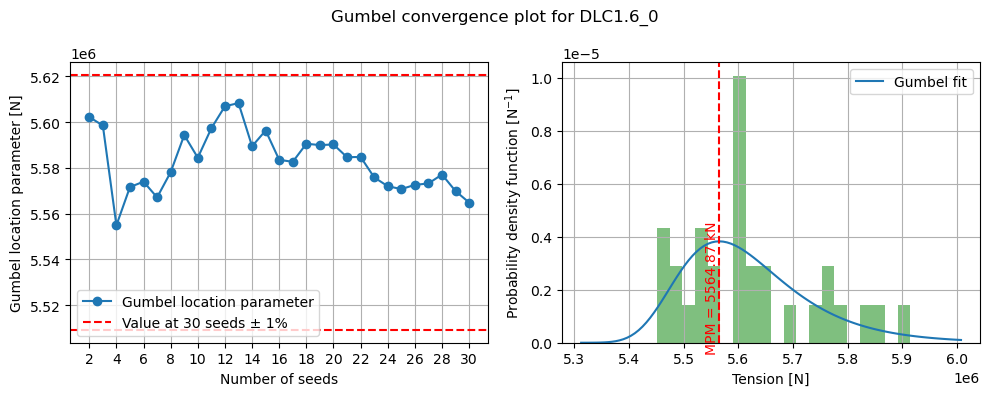

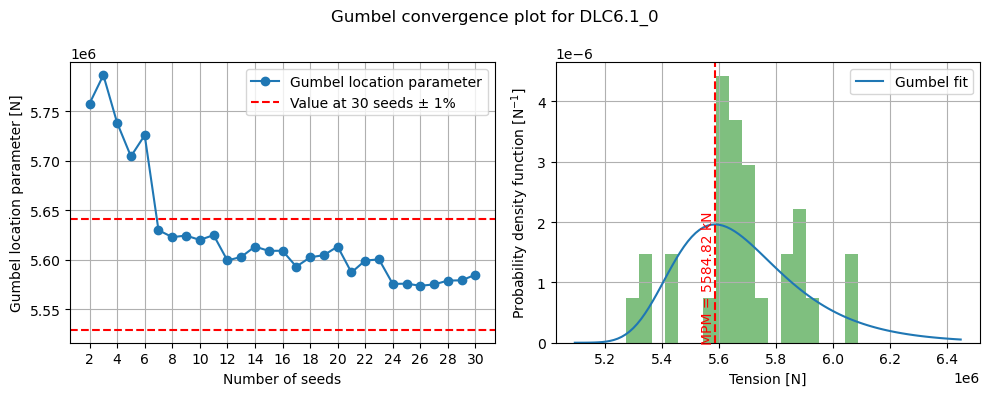

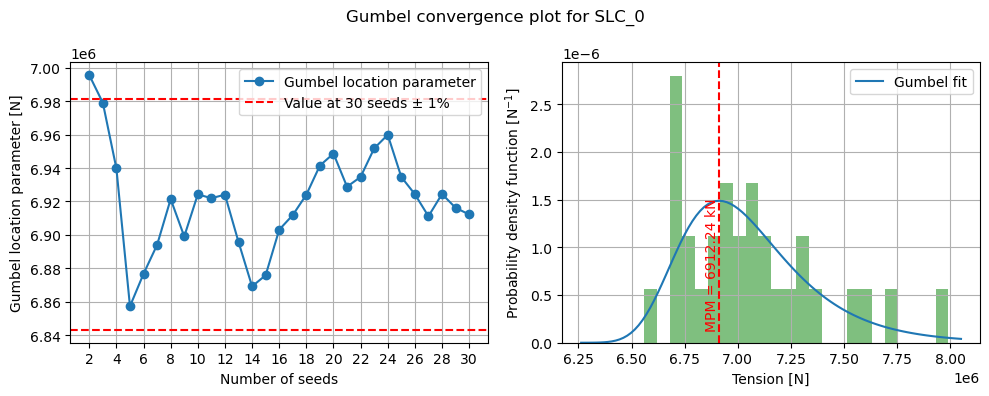

In [ ]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
nSeeds = pivot_df.shape[1]

gumbel_locDict = {}
gev_fitDict = {}
maxValsDict = {}

for index, row in pivot_df.iterrows():
    
    maxTenVals = row.values
    
    gumbel_locList = []
    gumbel_scaleList = []
    gumbel_seedList = []

    for i in range(2, len(maxTenVals)+1):
        val = maxTenVals[0:i]
        gumbel_loc, gumbel_scale = gumbel_r.fit(val)
        gumbel_locList.append(gumbel_loc)
        gumbel_scaleList.append(gumbel_scale)
        gumbel_seedList.append(len(val))

    gumbel_locDict[index] = [np.array(gumbel_seedList, dtype=np.int64), np.array(gumbel_locList), np.array(gumbel_scaleList)]

    #also do a GEV fit
    scaledParams = np.array(genextreme.fit(maxTenVals/1e6))  #scale the values to avoid numerical issues
    scaledParams[1:] = scaledParams[1:]*1e6 #leave out teh shape parameter which is not scaled
    gev_fitDict[index] = scaledParams

    maxValsDict[index] = maxTenVals
    

for ind, cond in enumerate(gumbel_locDict.keys()):

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    fig.suptitle(f'Gumbel convergence plot for {cond}')
    
    #gumbel convergence plot
    plt.sca(axs[0])
    plt.plot(gumbel_locDict[cond][0], gumbel_locDict[cond][1], '-o', label = 'Gumbel location parameter')
    tolPercent = 1
    plt.axhline(y = (1 +  tolPercent/100) * gumbel_locDict[cond][1][-1], color='red', linestyle='--', label=f'Value at {nSeeds} seeds ± {tolPercent}%')
    plt.axhline(y = (1 -  tolPercent/100) * gumbel_locDict[cond][1][-1], color='red', linestyle='--')
    plt.xticks(range(2, len(gumbel_locDict[cond][0])+2, 2))
    plt.grid()
    plt.legend()
    plt.xlabel('Number of seeds')
    plt.ylabel('Gumbel location parameter [N]')



    #gumbel pdf
    plt.sca(axs[1])
    gumbel_loc = gumbel_locDict[cond][1][-1]
    gumbel_scale = gumbel_locDict[cond][2][-1]
    x = np.linspace(gumbel_r.ppf(1e-6, scale=gumbel_scale, loc=gumbel_loc),
                    gumbel_r.ppf(0.99, scale=gumbel_scale, loc=gumbel_loc), 100)
    y = gumbel_r.pdf(x, scale=gumbel_scale, loc=gumbel_loc)
    plt.plot(x, y, label='Gumbel fit')
    y_min, y_max = plt.ylim()
    plt.text(gumbel_loc, np.max(y_max - y_min)/2, 
            f"MPM = {gumbel_loc/1000:.2f} kN", rotation=90, ha='right', va='center', color='r')
    plt.axvline(gumbel_loc, color='r', linestyle='--')
    plt.grid()
    plt.xlabel('Tension [N]')
    plt.ylabel(r'Probability density function [N$^{-1}$]')

    #plot the GEV fit
    # gev_fit = gev_fitDict[cond]
    # y_gev = genextreme.pdf(x, c=gev_fit[0], loc=gev_fit[1], scale=gev_fit[2])
    # print(f'Cond {cond} : Shape = {gev_fit[0]:.2f}, Location = {gev_fit[1]:.2f}, Scale = {gev_fit[2]:.2f}')
    # plt.plot(x, y_gev, label='GEV fit')

    #plot histogram
    plt.hist(maxValsDict[cond], bins=30, density=True, alpha=0.5, color='g', range=(x.min(), x.max()))

    plt.legend()

    fig.tight_layout()


### Safety factor check on MPM value

In [ ]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')

#gumbel fit
fit_df = pd.DataFrame()
fit_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
fit_df['gumbel_90Quantile'] = fit_df.apply(lambda row: gumbel_r.ppf(0.90, loc=row['gumbel_loc'], scale=row['gumbel_scale']), axis=1)
# pivot_df

#GEV fit
normaliseFact = 1e6 #for GEV fit the data needs to be normalised
fit_df[['gev_shape', 'gev_loc', 'gev_scale']] = pivot_df.apply(lambda row: pd.Series(genextreme.fit(row.values/normaliseFact)), axis=1)
fit_df['gev_loc'] = fit_df['gev_loc']*normaliseFact #scale them back
fit_df['gev_scale'] = fit_df['gev_scale']*normaliseFact 
fit_df['gev_90Quantile'] = fit_df.apply(lambda row: genextreme.ppf(0.90, c=row['gev_shape'], loc=row['gev_loc'], scale=row['gev_scale']), axis=1)

# pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
# pivot_df

Text(1.6, 1.02, 'SLC Safety factor = 1')

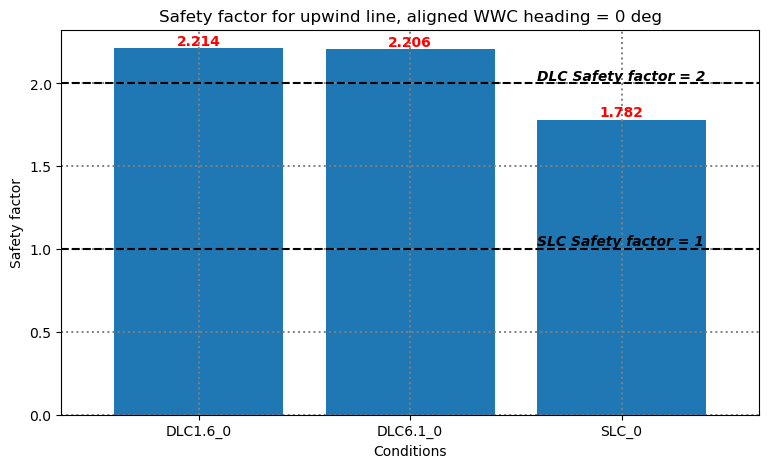

In [ ]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='FAIRTEN12')
pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_r.fit(row.values)), axis=1)
# pivot_df['90Quantile'] = pivot_df.apply(lambda row: gumbel_r.ppf(0.90, loc=row['gumbel_loc'], scale=row['gumbel_scale']), axis=1)

#plot the dataframe
safetyDf = polyMbl/pivot_df[['gumbel_loc']]
# safetyDf = polyMbl/fit_df[['gev_90Quantile']]

safetyDf.plot(kind='bar', figsize=(9, 5), width=0.8)
plt.xticks(rotation=0)
plt.title(f'Safety factor for upwind line, aligned WWC heading = {head} deg')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
plt.legend().remove()
plt.ylabel('Safety factor')
plt.xlabel('Conditions')

for i in range(len(safetyDf)):
    for j in range(len(safetyDf.columns)):
        value = safetyDf.iloc[i, j]  # Get the value from the DataFrame
        plt.annotate(f'{value:.3f}', xy=(i, value), ha='center', va='bottom', color='r', weight='bold')

plt.axhline(y=2, color='k', linestyle='--')
plt.axhline(y=1.0, color='k', linestyle='--')
plt.annotate('DLC Safety factor = 2', xy=(1.6, 2.02), fontstyle='italic', color='k', weight='bold')
plt.annotate('SLC Safety factor = 1', xy=(1.6, 1.02), fontstyle='italic', color='k', weight='bold')

# Minimum line tension at anchor

In [ ]:
valHeader =  [f'{ten}{ind}' for ind in range(7,13) for ten in ['ANCHTEN', 'FAIRTEN']]
valType   = 'min'
head = 180
minPd = checkTensionExtremes(sumDf, valHeader, valType, head)
minPd


min tensions occurring in ['ANCHTEN7'] and val is 141421.90625 @ Run_P200_C135_L1430_clump40_SLC_180_S27.outb


,ANCHTEN7,FAIRTEN7,ANCHTEN8,FAIRTEN8,ANCHTEN9,FAIRTEN9,ANCHTEN10,FAIRTEN10,ANCHTEN11,FAIRTEN11,ANCHTEN12,FAIRTEN12,minTenCol,minTen,cond_head,seed,heading,polyDia
Run_P200_C135_L1430_clump40_DLC1.6_180_S1.outb,444419.437500,461591.562500,461908.50000,476712.593750,679165.50000,711399.43750,712669.75000,748269.87500,750033.87500,761599.56250,763741.6250,850180.43750,ANCHTEN7,444419.437500,DLC1.6_180,01,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S10.outb,428895.406250,445187.531250,445392.37500,460450.750000,667410.25000,699806.93750,701044.25000,736139.93750,737679.06250,749020.00000,750737.0625,830771.75000,ANCHTEN7,428895.406250,DLC1.6_180,10,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S11.outb,443373.437500,459722.000000,459942.68750,474120.875000,678327.81250,710725.00000,711786.06250,746633.06250,748007.06250,759311.93750,760970.8750,850478.50000,ANCHTEN7,443373.437500,DLC1.6_180,11,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S12.outb,451555.187500,468641.656250,468943.28125,483914.531250,687754.37500,719522.43750,720634.12500,755245.68750,756672.25000,767490.62500,769159.7500,845675.06250,ANCHTEN7,451555.187500,DLC1.6_180,12,180.0,0.2
Run_P200_C135_L1430_clump40_DLC1.6_180_S13.outb,414890.968750,430521.968750,430733.40625,446026.718750,650583.43750,682607.68750,683713.37500,718728.37500,720290.87500,731643.43750,733502.6875,808885.18750,ANCHTEN7,414890.968750,DLC1.6_180,13,180.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Run_P200_C135_L1430_clump40_SLC_180_S5.outb,271756.000000,290009.812500,291100.78125,310241.875000,510451.96875,541733.87500,542910.12500,578441.06250,580137.06250,591319.68750,593260.3125,655423.00000,ANCHTEN7,271756.000000,SLC_180,05,180.0,0.2
Run_P200_C135_L1430_clump40_SLC_180_S6.outb,241359.453125,267084.843750,268417.87500,288350.562500,491951.00000,521725.43750,522815.65625,558111.93750,559591.62500,570727.87500,572483.4375,626287.43750,ANCHTEN7,241359.453125,SLC_180,06,180.0,0.2
Run_P200_C135_L1430_clump40_SLC_180_S7.outb,240266.281250,259770.796875,265641.25000,289220.062500,491092.31250,521461.71875,522739.75000,558929.43750,560766.31250,572117.87500,574363.4375,627287.93750,ANCHTEN7,240266.281250,SLC_180,07,180.0,0.2
Run_P200_C135_L1430_clump40_SLC_180_S8.outb,230279.718750,251934.296875,252438.28125,276644.968750,477663.12500,506825.18750,507874.21875,542230.18750,543532.62500,554515.62500,556164.3750,601460.56250,ANCHTEN7,230279.718750,SLC_180,08,180.0,0.2


* WWC aligned, 0 deg heading for Line 1 and 3
* WWC aligned, 180 deg heading for Line 2

In [ ]:
valHeader = ['ANCHTEN1', 'ANCHTEN7', 'ANCHTEN13']
valType   = 'min'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() 
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']


linHeadDict = {'ANCHTEN1': 0, 
               'ANCHTEN7': 180, 
               'ANCHTEN13': 0}

lineNamesDict = {'ANCHTEN1' : 'Line 1', 
             'ANCHTEN7' : 'Line 2', 
             'ANCHTEN13' : 'Line 3'}

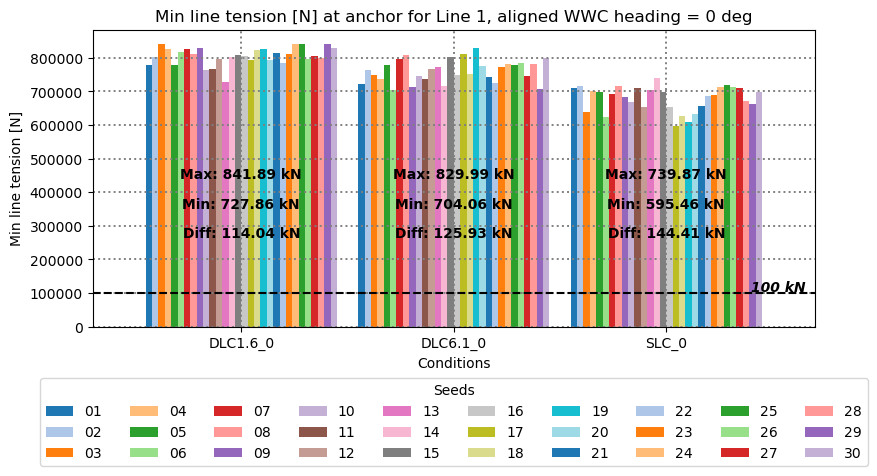

Min line tension [N] at anchor for Line 1, aligned WWC heading = 0 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 778847 | 802126 | 840844 | 825040 | 779199 | 816536 |
| DLC6.1_0    | 721133 | 762608 | 748506 | 737112 | 779220 | 704062 |
| SLC_0       | 711028 | 714615 | 638823 | 701222 | 697046 | 624634 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 826836 | 812061 | 829081 | 764598 | 765465 | 796195 |
| DLC6.1_0    | 796556 | 807942 | 711818 | 746860 | 736181 | 766315 |
| SLC_0       | 692667 | 715076 | 683338 | 668461 | 710144 | 654234 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 727858 | 803662 | 806787 | 804969 | 794362 | 823870 |
| DLC6.1_0    | 773410 | 717025 | 802578 | 747594 | 810189 | 752582 |
| SLC_0       | 704310 | 739873 | 696721 | 651941 | 595464 | 625937 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 827110 | 794653 | 813486 | 785650 | 811445 | 841894 |
| DLC6.1_0    | 829994 | 776566 | 742486 | 724246 | 773328 | 782763 |
| SLC_0       | 609117 | 631108 | 655863 | 686664 | 688869 | 712624 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 840650 | 796928 | 805387 | 800206 | 840836 | 828455 |
| DLC6.1_0    | 778437 | 783503 | 745897 | 780884 | 708117 | 800337 |
| SLC_0       | 719103 | 712269 | 710098 | 671321 | 663496 | 697557 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_0    | 727858 | 841894 |
| DLC6.1_0    | 704062 | 829994 |
| SLC_0       | 595464 | 739873 |

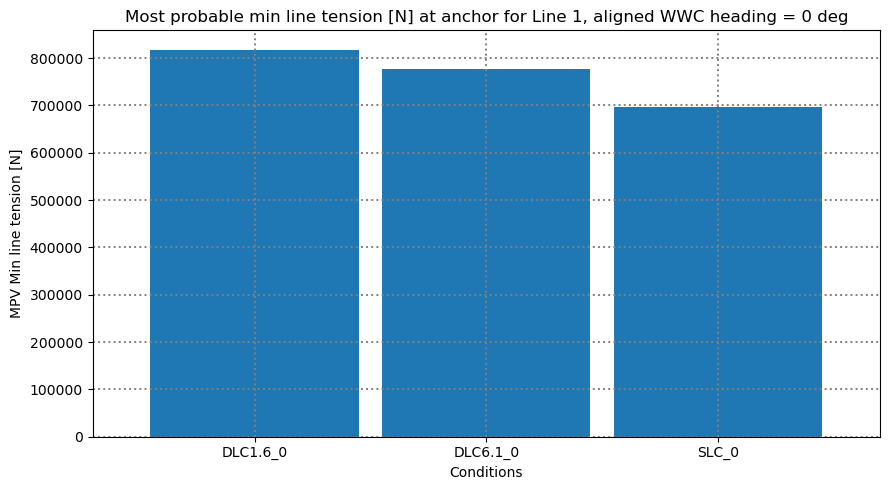

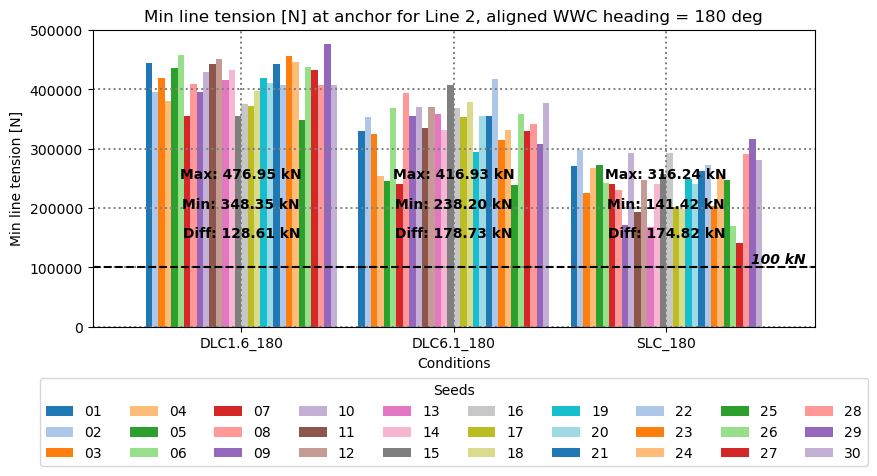

Min line tension [N] at anchor for Line 2, aligned WWC heading = 180 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 444419 | 395403 | 419818 | 380053 | 435481 | 457751 |
| DLC6.1_180  | 329345 | 353666 | 324365 | 253083 | 244581 | 368469 |
| SLC_180     | 270684 | 297317 | 225120 | 267753 | 271756 | 241359 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 354836 | 409521 | 395503 | 428895 | 443373 | 451555 |
| DLC6.1_180  | 240167 | 393861 | 354997 | 370629 | 334085 | 370926 |
| SLC_180     | 240266 | 230280 | 170719 | 293034 | 193451 | 247866 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 414891 | 431751 | 354269 | 375279 | 372305 | 397243 |
| DLC6.1_180  | 357565 | 332203 | 406869 | 369003 | 353994 | 378954 |
| SLC_180     | 167664 | 240184 | 257235 | 292589 | 200860 | 197470 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 418978 | 411242 | 442368 | 407318 | 456999 | 446096 |
| DLC6.1_180  | 294293 | 354852 | 355549 | 416930 | 315306 | 331387 |
| SLC_180     | 249177 | 240957 | 262679 | 272355 | 203487 | 257640 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_180  | 348346 | 438446 | 432675 | 406984 | 476952 | 407946 |
| DLC6.1_180  | 238196 | 358292 | 329982 | 341461 | 308626 | 376608 |
| SLC_180     | 247416 | 169589 | 141422 | 290150 | 316239 | 280707 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_180  | 348346 | 476952 |
| DLC6.1_180  | 238196 | 416930 |
| SLC_180     | 141422 | 316239 |

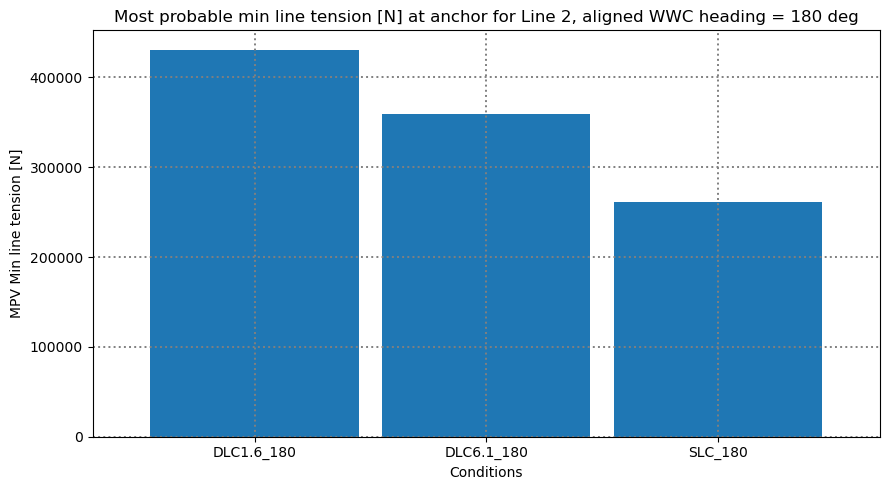

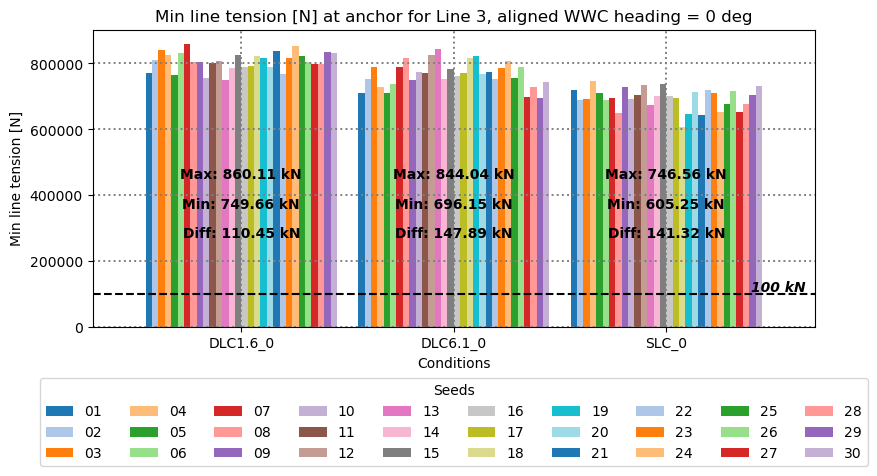

Min line tension [N] at anchor for Line 3, aligned WWC heading = 0 deg


| cond_head   |     01 |     02 |     03 |     04 |     05 |     06 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 771085 | 810586 | 840647 | 826835 | 763798 | 832343 |
| DLC6.1_0    | 709555 | 751591 | 787748 | 729817 | 710589 | 736283 |
| SLC_0       | 718752 | 690278 | 691899 | 746563 | 710550 | 689103 |

| cond_head   |     07 |     08 |     09 |     10 |     11 |     12 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 860114 | 804980 | 803079 | 757127 | 801373 | 806102 |
| DLC6.1_0    | 788602 | 815106 | 748941 | 773112 | 770366 | 826352 |
| SLC_0       | 694505 | 650713 | 728951 | 690682 | 704335 | 733465 |

| cond_head   |     13 |     14 |     15 |     16 |     17 |     18 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 749664 | 784726 | 825171 | 789149 | 790854 | 823137 |
| DLC6.1_0    | 844040 | 752784 | 783469 | 761668 | 771196 | 817145 |
| SLC_0       | 673996 | 700948 | 738318 | 700345 | 694629 | 605246 |

| cond_head   |     19 |     20 |     21 |     22 |     23 |     24 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 815650 | 790268 | 838714 | 767410 | 817100 | 852179 |
| DLC6.1_0    | 821970 | 767684 | 775030 | 753416 | 786913 | 808697 |
| SLC_0       | 644936 | 714237 | 642696 | 720696 | 709794 | 652740 |

| cond_head   |     25 |     26 |     27 |     28 |     29 |     30 |
|:------------|-------:|-------:|-------:|-------:|-------:|-------:|
| DLC1.6_0    | 823182 | 805467 | 798161 | 799665 | 833717 | 831919 |
| DLC6.1_0    | 754853 | 789295 | 698026 | 728755 | 696149 | 742734 |
| SLC_0       | 677461 | 714936 | 653799 | 675772 | 704289 | 731744 |

| cond_head   |    min |    max |
|:------------|-------:|-------:|
| DLC1.6_0    | 749664 | 860114 |
| DLC6.1_0    | 696149 | 844040 |
| SLC_0       | 605246 | 746563 |

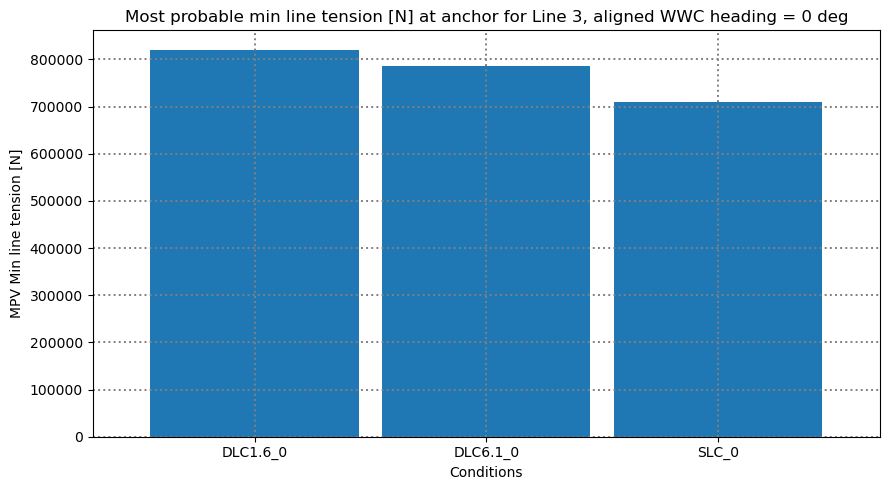

In [ ]:
for lineID, head in linHeadDict.items():

    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()

    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)

    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'Min line tension [N]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
    plt.tight_layout()
    


    #minimum tensions
    pivot_df['min'] = pivot_df.min(axis=1)
    pivot_df['max'] = pivot_df.max(axis=1)

    dist =  np.mean(plt.ylim()) * 0.2

    for index, row in pivot_df.iterrows():
        x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
        plt.annotate(f'Max: {row["max"]/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim())),
                    ha='center', color='k', weight='bold')
        plt.annotate(f'Min: {row["min"]/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                    ha='center', color='k', weight='bold')
        #difference
        plt.annotate(f'Diff: {(row["max"]-row["min"])/1000:.2f} kN', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                    ha='center', color='k', weight='bold')
 
    plt.axhline(y = 100*1e3, color='k', linestyle='--')
    xLims = plt.xlim() 
    plt.text(xLims[1] -.3, 1.06 * 100*1e3, '100 kN', fontstyle='italic', color='k', weight='bold')
    plt.show()

    print(f"Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg")
    displayDf(pivot_df, nCols = 6)


    


    #------------ plot the most probable minimum tension value -----------
    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()

    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)

    pivot_df[['gumbel_loc', 'gumbel_scale']] = pivot_df.apply(lambda row: pd.Series(gumbel_l.fit(row.values)), axis=1)

    pivot_df = pivot_df[['gumbel_loc']]

    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Most probable min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'MPV Min line tension [N]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.tight_layout()
    plt.legend().remove()


    # plt.axhline(y=0.1*preTension, color='k', linestyle='--')
    # plt.annotate('10% of Pretension', xy=(1.6, 1.02 * 0.1 * preTension), fontstyle='italic', color='k', weight='bold')


    

* The min tensions at anchor goes slack for SLC condition eventhough it shows 21.8 kN -> not able to find the reason for this small value to be always present.

# Minimum height of botom chain top node from the seabed

* WWC aligned, 0 deg heading for Line 1 and 3
* WWC aligned, 180 deg heading for Line 2

In [ ]:
waterDepth = 800
valHeader = ['CON2PZ', 'CON9PZ', 'CON16PZ']
valType   = 'min'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() + waterDepth #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']


linHeadDict = {'CON2PZ': 0, 
               'CON9PZ': 180, 
               'CON16PZ': 0}

lineNamesDict = {   'CON2PZ' : 'Line 1', 
                    'CON9PZ': 'Line 2', 
                    'CON16PZ' : 'Line 3'}

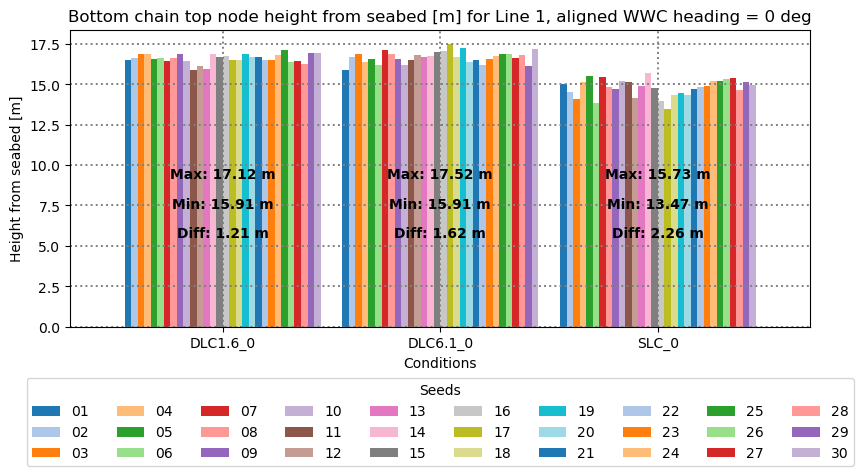

Min line tension [N] at anchor for Line 1, aligned WWC heading = 0 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.5272 | 16.6251 | 16.8554 | 16.8863 | 16.6018 | 16.6449 |
| DLC6.1_0    | 15.9062 | 16.7127 | 16.8693 | 16.4136 | 16.5642 | 16.1854 |
| SLC_0       | 15.0405 | 14.4991 | 14.0747 | 15.1772 | 15.5433 | 13.8444 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.4572 | 16.6442 | 16.8911 | 16.4536 | 15.9109 | 16.1436 |
| DLC6.1_0    | 17.1566 | 16.8753 | 16.5496 | 16.2151 | 16.5397 | 16.8345 |
| SLC_0       | 15.4497 | 14.8564 | 14.7057 | 15.2291 | 15.1373 | 14.1776 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 15.9485 | 16.9043 | 16.6825 | 16.7831 | 16.5268 | 16.5031 |
| DLC6.1_0    | 16.6795 | 16.7347 | 17.037  | 17.0638 | 17.5228 | 16.6797 |
| SLC_0       | 14.9235 | 15.732  | 14.7939 | 13.9598 | 13.4724 | 14.3302 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.8817 | 16.6666 | 16.7245 | 16.511  | 16.5418 | 16.7953 |
| DLC6.1_0    | 17.2543 | 16.4117 | 16.5331 | 16.2007 | 16.5942 | 16.7451 |
| SLC_0       | 14.4751 | 14.3618 | 14.6916 | 14.8486 | 14.8849 | 15.2054 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 17.1176 | 16.3671 | 16.4381 | 16.2351 | 16.9738 | 16.9479 |
| DLC6.1_0    | 16.8637 | 16.8612 | 16.6415 | 16.8243 | 16.1529 | 17.1652 |
| SLC_0       | 15.231  | 15.3585 | 15.3986 | 14.6267 | 15.1518 | 14.9398 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 15.9109 | 17.1176 |
| DLC6.1_0    | 15.9062 | 17.5228 |
| SLC_0       | 13.4724 | 15.732  |

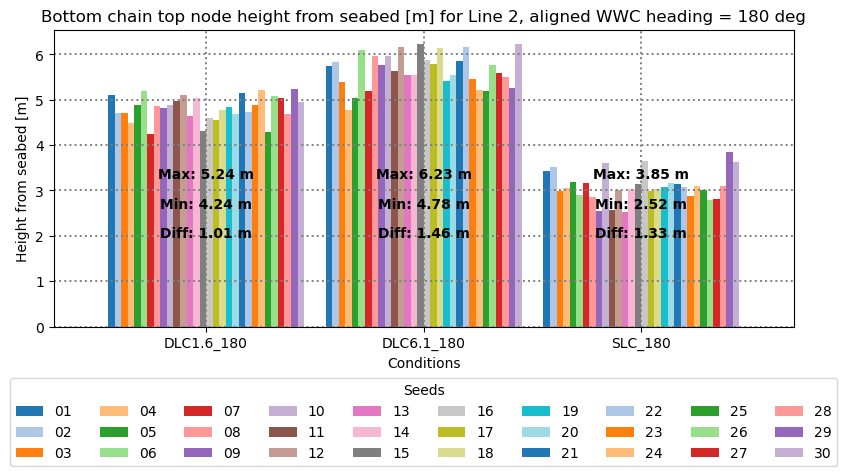

Min line tension [N] at anchor for Line 2, aligned WWC heading = 180 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 5.09753 | 4.71094 | 4.71429 | 4.48279 | 4.88373 | 5.1889  |
| DLC6.1_180  | 5.74323 | 5.81995 | 5.37946 | 4.77728 | 5.03174 | 6.09467 |
| SLC_180     | 3.42273 | 3.51379 | 2.99078 | 3.06403 | 3.19507 | 2.90857 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.23663 | 4.85919 | 4.8111  | 4.88995 | 4.98077 | 5.0946  |
| DLC6.1_180  | 5.18262 | 5.97369 | 5.76703 | 5.96552 | 5.62134 | 6.16522 |
| SLC_180     | 3.16754 | 2.86456 | 2.54901 | 3.59448 | 2.56775 | 3.01031 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.6405  | 5.03827 | 4.3089  | 4.59973 | 4.54889 | 4.76337 |
| DLC6.1_180  | 5.54535 | 5.53351 | 6.22974 | 5.87854 | 5.79199 | 6.13818 |
| SLC_180     | 2.51868 | 3.03827 | 3.14587 | 3.64624 | 2.99316 | 3.03833 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.8432  | 4.67657 | 5.13837 | 4.71936 | 4.8916  | 5.21332 |
| DLC6.1_180  | 5.40216 | 5.54041 | 5.85248 | 6.17139 | 5.46631 | 5.22137 |
| SLC_180     | 3.0683  | 3.159   | 3.15259 | 3.06641 | 2.8783  | 3.08728 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_180  | 4.28467 | 5.08002 | 5.02924 | 4.68427 | 5.24194 | 4.95898 |
| DLC6.1_180  | 5.18823 | 5.76001 | 5.58008 | 5.50098 | 5.25861 | 6.23456 |
| SLC_180     | 3.00616 | 2.79968 | 2.80524 | 3.10278 | 3.84528 | 3.63245 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_180  | 4.23663 | 5.24194 |
| DLC6.1_180  | 4.77728 | 6.23456 |
| SLC_180     | 2.51868 | 3.84528 |

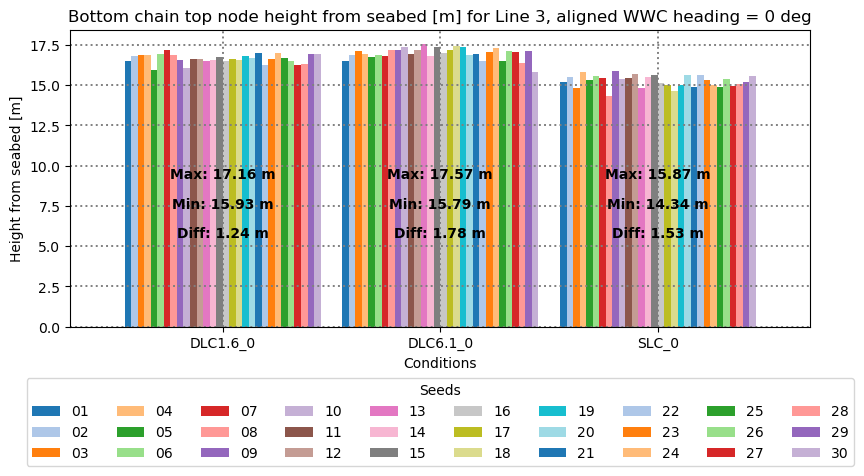

Min line tension [N] at anchor for Line 3, aligned WWC heading = 0 deg


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.4892 | 16.7833 | 16.8718 | 16.8699 | 15.9268 | 16.8947 |
| DLC6.1_0    | 16.4766 | 16.8643 | 17.1385 | 16.9314 | 16.7481 | 16.8597 |
| SLC_0       | 15.1937 | 15.4837 | 14.8091 | 15.8083 | 15.319  | 15.5315 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 17.1637 | 16.8352 | 16.556  | 16.0739 | 16.593  | 16.6312 |
| DLC6.1_0    | 16.8252 | 17.2015 | 17.158  | 17.3788 | 16.9245 | 17.1919 |
| SLC_0       | 15.4416 | 14.3421 | 15.8715 | 15.3737 | 15.4338 | 15.6729 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.4733 | 16.562  | 16.7468 | 16.4867 | 16.6212 | 16.5626 |
| DLC6.1_0    | 17.5654 | 16.8145 | 17.3537 | 16.9583 | 17.1926 | 17.3912 |
| SLC_0       | 14.8142 | 15.468  | 15.6259 | 15.1171 | 14.9797 | 14.6398 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.7766 | 16.6589 | 17.0113 | 16.2172 | 16.617  | 16.9578 |
| DLC6.1_0    | 17.3372 | 16.8925 | 16.9516 | 16.4842 | 17.0692 | 17.2974 |
| SLC_0       | 15.0141 | 15.607  | 14.8694 | 15.6053 | 15.2921 | 14.9796 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 16.6887 | 16.4849 | 16.2131 | 16.318  | 16.9232 | 16.9315 |
| DLC6.1_0    | 16.5099 | 17.1165 | 17.0472 | 16.3919 | 17.1352 | 15.787  |
| SLC_0       | 14.889  | 15.3869 | 14.9191 | 15.0477 | 15.2096 | 15.5709 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 15.9268 | 17.1637 |
| DLC6.1_0    | 15.787  | 17.5654 |
| SLC_0       | 14.3421 | 15.8715 |

In [ ]:
for lineID, head in linHeadDict.items():

    filt = maxPd['heading'] == head #select the heading case based on the line considered
    headFiltDf = maxPd[filt].copy()
    pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
    pivot_df.plot(kind='bar', width = 0.9, figsize=(9, 5), color = plt.cm.tab20.colors)


    plt.title(f'Bottom chain top node height from seabed [m] for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg')
    plt.xlabel('Conditions')
    plt.ylabel(f'Height from seabed [m]')
    plt.xticks(rotation=0)
    plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
    plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
    plt.tight_layout()

    #minimum tensions
    pivot_df['min'] = pivot_df.min(axis=1)
    pivot_df['max'] = pivot_df.max(axis=1)

    dist =  np.mean(plt.ylim()) * 0.2

    for index, row in pivot_df.iterrows():
        x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
        plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                    ha='center', color='k', weight='bold')
        plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                    ha='center', color='k', weight='bold')
        #difference
        plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                    ha='center', color='k', weight='bold')
 
        
    plt.show()

    print(f"Min line tension [N] at anchor for {lineNamesDict[lineID]}, aligned WWC heading = {head} deg")
    displayDf(pivot_df, nCols = 6)


# Max line tension at anchor

* WWC aligned, 0 deg heading for Line 2

In [ ]:
valHeader = ['ANCHTEN7', 'LINE7N0FZ', 'ANCH7HORZ']
valType   = 'max'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() 
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']
maxPd['heading']    = sumDf['heading']

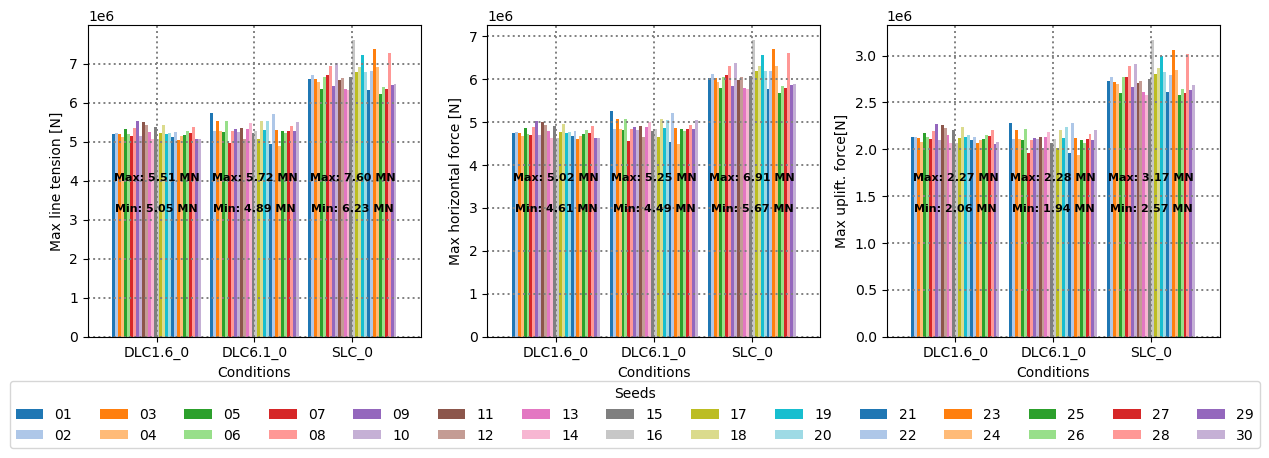

In [ ]:
head = 0
filt = maxPd['heading'] == head #select the heading case based on the line considered
headFiltDf = maxPd[filt].copy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


#Line tension at anchor
lineID = 'ANCHTEN7'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, ax = axs[0], legend = False)   
plt.sca(axs[0])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max line tension [N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)



#Line horizontal tension max at anchor
lineID = 'ANCH7HORZ'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, ax = axs[1], legend = False)   
plt.sca(axs[1])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max horizontal force [N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)

#Line vertical tension max at anchor
lineID = 'LINE7N0FZ'
pivot_df = headFiltDf.pivot(index='cond_head', columns='seed', values=lineID)
pivot_df.plot(kind='bar', width = 0.9, color = plt.cm.tab20.colors, legend = False, ax = axs[2])   
plt.sca(axs[2])
# plt.title(f'Max line tension [N] at anchor for {lineID}, aligned WWC heading = {head} deg')
plt.xlabel('Conditions')
plt.ylabel(f'Max uplift. force[N]')
plt.xticks(rotation=0)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")

pivot_df['min'] = pivot_df.min(axis=1)/1e6
pivot_df['max'] = pivot_df.max(axis=1)/1e6
dist =  np.mean(plt.ylim()) * 0.2
for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold', size=8)
    plt.annotate(f'Min: {row["min"]:.2f} MN', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold', size=8)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title = 'Seeds', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=15)
#get the legend
fig.tight_layout()


# plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
# fig.tight_layout()



## Load inclination angle

In [ ]:
#Design case
#Maximum tension at the anchor
df = df[df['heading'] == 0] 
df.loc[df.groupby('cond_head')['ANCHTEN7_[N]'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C135_L1430_clump40_DLC1.6_0_S9.outb,ANCHTEN7_[N],3804.525,5.514734e+06,24.351031,5.024108e+06,2.273861e+06
Run_P200_C135_L1430_clump40_DLC6.1_0_S1.outb,ANCHTEN7_[N],4038.500,5.722550e+06,23.502281,5.247830e+06,2.282070e+06
Run_P200_C135_L1430_clump40_SLC_0_S16.outb,ANCHTEN7_[N],1308.125,7.603754e+06,24.592675,6.913970e+06,3.164393e+06


In [ ]:
df = df[df['heading'] == 0] 
#Maximum horizontal tension at the anchor
df.loc[df.groupby('cond_head')['LINE7ANCH_HOR_TEN'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C135_L1430_clump40_DLC1.6_0_S9.outb,LINE7ANCH_HOR_TEN,3804.500,5.514675e+06,24.347887,5.024213e+06,2.273576e+06
Run_P200_C135_L1430_clump40_DLC6.1_0_S1.outb,LINE7ANCH_HOR_TEN,4038.475,5.722425e+06,23.497346,5.247886e+06,2.281557e+06
Run_P200_C135_L1430_clump40_SLC_0_S16.outb,LINE7ANCH_HOR_TEN,1308.100,7.603483e+06,24.588127,6.914050e+06,3.163767e+06


In [ ]:
#Maximum vertical tension at the anchor
df = df[df['heading'] == 0] 
df.loc[df.groupby('cond_head')['LINE7N0FZ_[N]'].idxmax(), ['t', 'ANCHTEN7_[N]','LINE7ANCH_UPLIFT_ANGLE',	'LINE7ANCH_HOR_TEN',	'LINE7N0FZ_[N]']]

,,t,ANCHTEN7_[N],LINE7ANCH_UPLIFT_ANGLE,LINE7ANCH_HOR_TEN,LINE7N0FZ_[N]
File,maxChannel,,,,,
Run_P200_C135_L1430_clump40_DLC1.6_0_S9.outb,LINE7N0FZ_[N],3804.675,5.512836e+06,24.368951,5.021686e+06,2.274657e+06
Run_P200_C135_L1430_clump40_DLC6.1_0_S1.outb,LINE7N0FZ_[N],4038.675,5.719498e+06,23.534287,5.243752e+06,2.283781e+06
Run_P200_C135_L1430_clump40_SLC_0_S16.outb,LINE7N0FZ_[N],1308.300,7.600137e+06,24.623567,6.908963e+06,3.166608e+06


Teh maximums are occuring at the same time - so the inclination angle does not seem to have any large effect

# Platform mean surge offset

In [ ]:
valHeader = ['PtfmSurge']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']

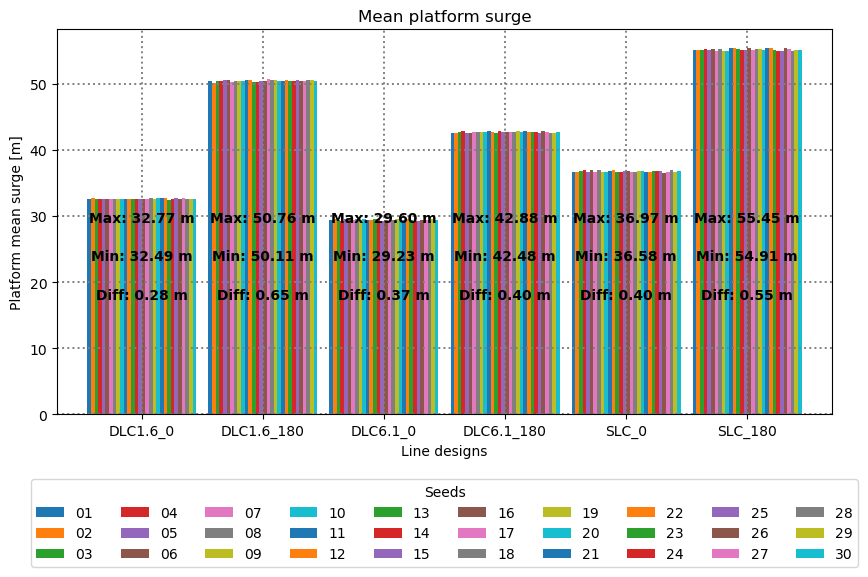

Mean platform surge [m]


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.6045 | 32.6796 | 32.6066 | 32.5456 | 32.5465 | 32.5059 |
| DLC1.6_180  | 50.3902 | 50.1131 | 50.4541 | 50.4369 | 50.4991 | 50.5675 |
| DLC6.1_0    | 29.3665 | 29.603  | 29.4702 | 29.3023 | 29.5784 | 29.4121 |
| DLC6.1_180  | 42.4781 | 42.6016 | 42.7743 | 42.7943 | 42.6124 | 42.6104 |
| SLC_0       | 36.6252 | 36.6855 | 36.8626 | 36.9014 | 36.6189 | 36.8882 |
| SLC_180     | 55.1668 | 55.1584 | 55.1389 | 55.2223 | 55.1088 | 55.2604 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.5467 | 32.582  | 32.6268 | 32.5871 | 32.5618 | 32.4987 |
| DLC1.6_180  | 50.2597 | 50.3951 | 50.4133 | 50.3519 | 50.4991 | 50.5203 |
| DLC6.1_0    | 29.3658 | 29.578  | 29.3707 | 29.4839 | 29.4656 | 29.328  |
| DLC6.1_180  | 42.6722 | 42.6292 | 42.6964 | 42.7529 | 42.823  | 42.6475 |
| SLC_0       | 36.7174 | 36.9723 | 36.6145 | 36.633  | 36.8037 | 36.9093 |
| SLC_180     | 54.9121 | 55.2965 | 55.0185 | 55.0117 | 55.3511 | 55.3893 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.6033 | 32.5502 | 32.5598 | 32.5064 | 32.5918 | 32.6705 |
| DLC1.6_180  | 50.2864 | 50.2935 | 50.406  | 50.4681 | 50.7597 | 50.5044 |
| DLC6.1_0    | 29.514  | 29.5572 | 29.2324 | 29.386  | 29.3055 | 29.4135 |
| DLC6.1_180  | 42.6231 | 42.8807 | 42.7093 | 42.6439 | 42.6361 | 42.7777 |
| SLC_0       | 36.6321 | 36.6515 | 36.7956 | 36.8542 | 36.6496 | 36.6176 |
| SLC_180     | 55.2513 | 55.1106 | 55.1002 | 55.3429 | 55.126  | 55.2107 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.5037 | 32.652  | 32.677  | 32.7746 | 32.4899 | 32.6208 |
| DLC1.6_180  | 50.5004 | 50.392  | 50.46   | 50.505  | 50.446  | 50.4126 |
| DLC6.1_0    | 29.5346 | 29.4544 | 29.3894 | 29.5525 | 29.3844 | 29.2771 |
| DLC6.1_180  | 42.8281 | 42.6799 | 42.8461 | 42.6963 | 42.7503 | 42.7315 |
| SLC_0       | 36.806  | 36.8182 | 36.6271 | 36.7056 | 36.8464 | 36.7383 |
| SLC_180     | 55.2975 | 55.1109 | 55.3381 | 55.4539 | 55.1238 | 54.9062 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 32.7329 | 32.5404 | 32.7316 | 32.6442 | 32.6106 | 32.5843 |
| DLC1.6_180  | 50.5737 | 50.4012 | 50.4466 | 50.5163 | 50.5243 | 50.386  |
| DLC6.1_0    | 29.2905 | 29.3672 | 29.4036 | 29.4538 | 29.5231 | 29.3809 |
| DLC6.1_180  | 42.5974 | 42.7924 | 42.6546 | 42.5773 | 42.6008 | 42.7411 |
| SLC_0       | 36.7516 | 36.5764 | 36.7179 | 36.9617 | 36.6739 | 36.7404 |
| SLC_180     | 54.9479 | 55.3396 | 55.2741 | 54.9375 | 55.0434 | 55.1605 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 32.4899 | 32.7746 |
| DLC1.6_180  | 50.1131 | 50.7597 |
| DLC6.1_0    | 29.2324 | 29.603  |
| DLC6.1_180  | 42.4781 | 42.8807 |
| SLC_0       | 36.5764 | 36.9723 |
| SLC_180     | 54.9062 | 55.4539 |

In [ ]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='PtfmSurge')

pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Line designs')
plt.ylabel('Platform mean surge [m]')
plt.xticks(rotation=0)
plt.title('Mean platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Mean platform surge [m]')
displayDf(pivot_df, nCols = 6)

## Platform heave

In [ ]:
valHeader = ['PtfmHeave']
valType   = 'mean'
maxPd               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
maxPd['cond_head']  = sumDf['cond_head']
maxPd['seed']       = sumDf['seed']

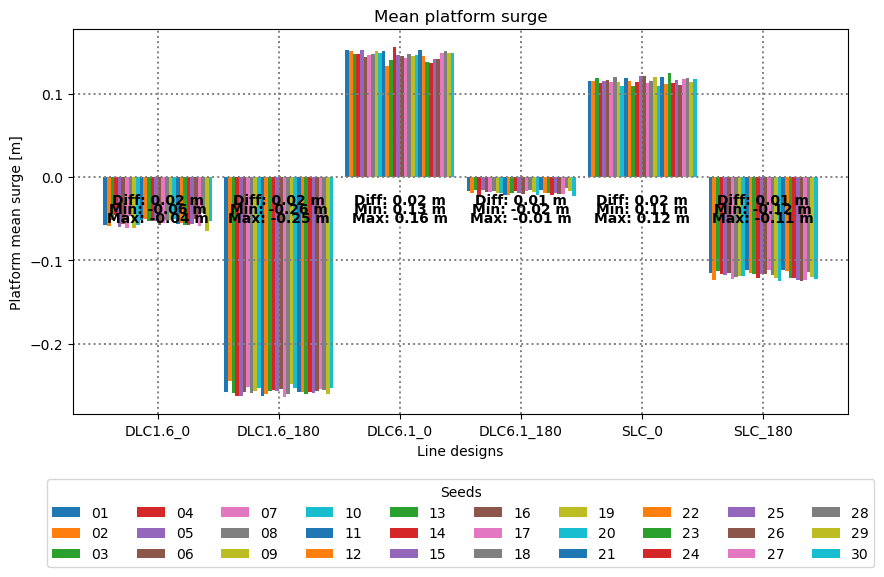

Mean platform surge [m]


| cond_head   |         01 |         02 |         03 |         04 |         05 |         06 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0579572 | -0.05895   | -0.0514658 | -0.0454766 | -0.0603202 | -0.0567967 |
| DLC1.6_180  | -0.257608  | -0.245074  | -0.258615  | -0.262385  | -0.263114  | -0.257903  |
| DLC6.1_0    |  0.152531  |  0.150818  |  0.147896  |  0.147896  |  0.151741  |  0.14431   |
| DLC6.1_180  | -0.0163067 | -0.0194374 | -0.0159631 | -0.021418  | -0.0158714 | -0.0186397 |
| SLC_0       |  0.115268  |  0.114787  |  0.118503  |  0.112726  |  0.115523  |  0.115966  |
| SLC_180     | -0.115105  | -0.124118  | -0.112558  | -0.115882  | -0.117072  | -0.114909  |

| cond_head   |         07 |         08 |         09 |         10 |         11 |         12 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0616309 | -0.0465022 | -0.0617681 | -0.0578699 | -0.0515308 | -0.0503418 |
| DLC1.6_180  | -0.251647  | -0.259308  | -0.257256  | -0.252558  | -0.262459  | -0.260846  |
| DLC6.1_0    |  0.145661  |  0.146865  |  0.150584  |  0.148762  |  0.150562  |  0.133296  |
| DLC6.1_180  | -0.0178637 | -0.0168255 | -0.0188696 | -0.0191765 | -0.0220704 | -0.0213009 |
| SLC_0       |  0.114305  |  0.119605  |  0.113845  |  0.108682  |  0.118977  |  0.115587  |
| SLC_180     | -0.122409  | -0.120362  | -0.119381  | -0.118534  | -0.111315  | -0.115381  |

| cond_head   |         13 |         14 |         15 |         16 |         17 |         18 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0531097 | -0.0523958 | -0.0525077 | -0.0581169 | -0.0546767 | -0.0518422 |
| DLC1.6_180  | -0.256615  | -0.255194  | -0.256349  | -0.254088  | -0.263736  | -0.260144  |
| DLC6.1_0    |  0.139859  |  0.155958  |  0.14607   |  0.145286  |  0.143133  |  0.147436  |
| DLC6.1_180  | -0.0188254 | -0.0173801 | -0.018692  | -0.0205191 | -0.0168068 | -0.0159213 |
| SLC_0       |  0.108747  |  0.113281  |  0.121575  |  0.121041  |  0.112082  |  0.115507  |
| SLC_180     | -0.11643   | -0.121777  | -0.116647  | -0.116732  | -0.111534  | -0.117161  |

| cond_head   |         19 |         20 |         21 |         22 |         23 |         24 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0516371 | -0.0505244 | -0.0560878 | -0.0550397 | -0.0577836 | -0.0578414 |
| DLC1.6_180  | -0.248178  | -0.252973  | -0.257854  | -0.257376  | -0.260186  | -0.258238  |
| DLC6.1_0    |  0.14454   |  0.145607  |  0.152227  |  0.144491  |  0.137757  |  0.136543  |
| DLC6.1_180  | -0.0175143 | -0.021546  | -0.0157398 | -0.0195892 | -0.0195371 | -0.0221248 |
| SLC_0       |  0.119497  |  0.109611  |  0.119974  |  0.111728  |  0.124396  |  0.112331  |
| SLC_180     | -0.120847  | -0.12439   | -0.111994  | -0.112853  | -0.12096   | -0.120859  |

| cond_head   |         25 |         26 |         27 |         28 |         29 |         30 |
|:------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| DLC1.6_0    | -0.0561238 | -0.0499952 | -0.0591226 | -0.0436498 | -0.0646515 | -0.053376  |
| DLC1.6_180  | -0.259329  | -0.256816  | -0.253852  | -0.255082  | -0.260396  | -0.253673  |
| DLC6.1_0    |  0.141623  |  0.141171  |  0.148394  |  0.151043  |  0.14916   |  0.149144  |
| DLC6.1_180  | -0.0194091 | -0.0200716 | -0.0205031 | -0.0138126 | -0.016378  | -0.0226635 |
| SLC_0       |  0.115742  |  0.109723  |  0.118018  |  0.119165  |  0.114261  |  0.116983  |
| SLC_180     | -0.123765  | -0.124458  | -0.123283  | -0.114221  | -0.120111  | -0.121811  |

| cond_head   |        min |        max |
|:------------|-----------:|-----------:|
| DLC1.6_0    | -0.0646515 | -0.0436498 |
| DLC1.6_180  | -0.263736  | -0.245074  |
| DLC6.1_0    |  0.133296  |  0.155958  |
| DLC6.1_180  | -0.0226635 | -0.0138126 |
| SLC_0       |  0.108682  |  0.124396  |
| SLC_180     | -0.124458  | -0.111315  |

In [ ]:
pivot_df = maxPd.pivot(index='cond_head', columns='seed', values='PtfmHeave')

# pivot_df.loc['DLC1.6_180', :] = -1 * pivot_df.loc['DLC1.6_180', :] #invert the surge for the 180 deg heading
# pivot_df.loc['DLC6.1_180', :] = -1 * pivot_df.loc['DLC6.1_180', :] 
# pivot_df.loc['SLC_180', :] = -1 * pivot_df.loc['SLC_180', :] 

pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Line designs')
plt.ylabel('Platform mean surge [m]')
plt.xticks(rotation=0)
plt.title('Mean platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')

plt.show()

print('Mean platform surge [m]')
displayDf(pivot_df, nCols = 6)

# Maximum platform surge offset

In [ ]:
valHeader = ['PtfmSurge']
valType   = 'max'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']



valHeader = ['PtfmSurge']
valType   = 'min'
dataDf2               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line


dataDf3 = dataDf1.copy()
filt = dataDf3['PtfmSurge'] < 0
dataDf3.loc[filt, 'PtfmSurge'] = -1*dataDf2.loc[filt, 'PtfmSurge'] #replace the negative values with the min values, and make them positive


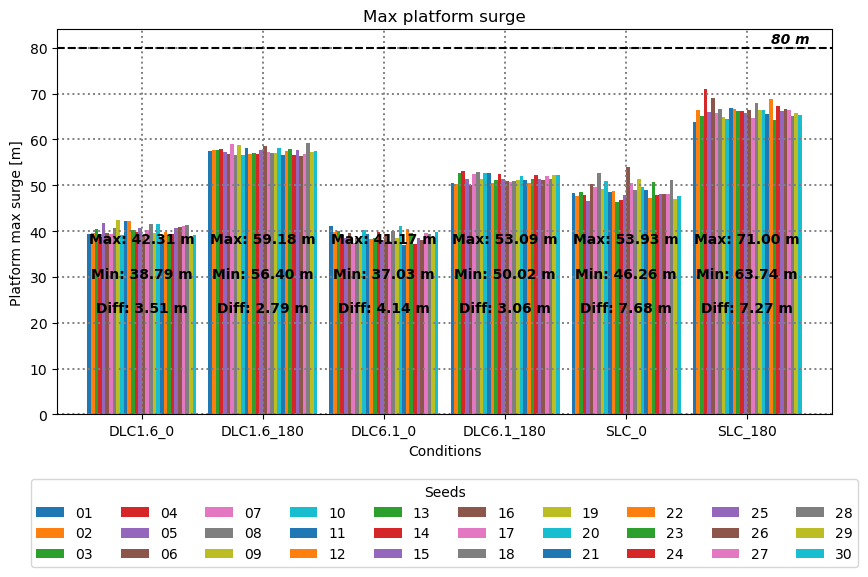

Max platform surge [m]


| cond_head   |      01 |      02 |      03 |      04 |      05 |      06 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 39.4298 | 39.6348 | 40.4402 | 38.7946 | 41.7695 | 39.4692 |
| DLC1.6_180  | 57.55   | 57.7186 | 57.6332 | 57.8924 | 57.1483 | 56.8344 |
| DLC6.1_0    | 41.1665 | 39.8814 | 39.9392 | 39.0412 | 38.483  | 39.5072 |
| DLC6.1_180  | 50.5096 | 50.1819 | 52.6943 | 53.086  | 51.3342 | 50.0214 |
| SLC_0       | 48.3502 | 47.5938 | 48.4651 | 47.7932 | 46.6265 | 50.3545 |
| SLC_180     | 63.736  | 66.3905 | 65.1317 | 71.0045 | 66.0536 | 69.0912 |

| cond_head   |      07 |      08 |      09 |      10 |      11 |      12 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 39.4524 | 40.6283 | 42.3076 | 39.055  | 42.297  | 42.1763 |
| DLC1.6_180  | 59.0231 | 56.6646 | 58.849  | 56.6086 | 58.2004 | 56.7244 |
| DLC6.1_0    | 37.3172 | 38.5573 | 38.4157 | 40.2254 | 39.429  | 38.2473 |
| DLC6.1_180  | 52.4076 | 52.9458 | 51.3863 | 52.6681 | 52.7642 | 50.403  |
| SLC_0       | 49.6517 | 52.6778 | 49.2596 | 50.8507 | 48.6122 | 48.7466 |
| SLC_180     | 65.6914 | 66.6492 | 64.8971 | 64.3542 | 66.8295 | 66.7222 |

| cond_head   |      13 |      14 |      15 |      16 |      17 |      18 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 40.1208 | 39.8125 | 40.702  | 39.1104 | 40.2767 | 41.4537 |
| DLC1.6_180  | 56.9928 | 56.8137 | 57.7636 | 58.4604 | 57.1423 | 57.0553 |
| DLC6.1_0    | 38.5804 | 39.7408 | 38.0446 | 39.4449 | 37.9085 | 39.914  |
| DLC6.1_180  | 51.089  | 52.4142 | 51.3367 | 50.957  | 50.7041 | 50.8652 |
| SLC_0       | 46.256  | 46.6642 | 47.7958 | 53.9324 | 50.4363 | 48.9359 |
| SLC_180     | 66.2495 | 66.2507 | 65.6665 | 66.3532 | 64.6821 | 67.9646 |

| cond_head   |      19 |      20 |      21 |      22 |      23 |      24 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 39.6091 | 41.4583 | 38.7991 | 39.7582 | 38.8675 | 39.3128 |
| DLC1.6_180  | 57.1282 | 58.1374 | 56.5273 | 57.4757 | 57.9808 | 56.5771 |
| DLC6.1_0    | 38.541  | 41.1471 | 37.0284 | 40.498  | 39.5794 | 37.2333 |
| DLC6.1_180  | 51.2032 | 52.077  | 51.1429 | 50.5762 | 51.34   | 52.1966 |
| SLC_0       | 51.4171 | 49.5211 | 49.0359 | 47.2868 | 50.6983 | 47.9372 |
| SLC_180     | 66.3172 | 66.3135 | 65.4248 | 68.763  | 64.3316 | 67.2969 |

| cond_head   |      25 |      26 |      27 |      28 |      29 |      30 |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|
| DLC1.6_0    | 40.6537 | 40.8934 | 41.1343 | 41.2113 | 38.9603 | 39.0625 |
| DLC1.6_180  | 57.6822 | 56.3962 | 56.733  | 59.1845 | 57.1519 | 57.3698 |
| DLC6.1_0    | 38.3772 | 37.9883 | 39.5646 | 39.3315 | 38.4905 | 39.7198 |
| DLC6.1_180  | 51.3177 | 51.1366 | 52.0897 | 51.2732 | 52.2908 | 52.2024 |
| SLC_0       | 48.0425 | 48.0623 | 48.0364 | 51.2088 | 47.0428 | 47.5725 |
| SLC_180     | 66.1194 | 66.6706 | 66.2999 | 65.1949 | 65.7462 | 65.3976 |

| cond_head   |     min |     max |
|:------------|--------:|--------:|
| DLC1.6_0    | 38.7946 | 42.3076 |
| DLC1.6_180  | 56.3962 | 59.1845 |
| DLC6.1_0    | 37.0284 | 41.1665 |
| DLC6.1_180  | 50.0214 | 53.086  |
| SLC_0       | 46.256  | 53.9324 |
| SLC_180     | 63.736  | 71.0045 |

In [ ]:
pivot_df = dataDf3.pivot(index='cond_head', columns='seed', values='PtfmSurge')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform max surge [m]')
plt.xticks(rotation=0)
plt.title('Max platform surge')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



pivot_df['min'] = pivot_df.min(axis=1)
pivot_df['max'] = pivot_df.max(axis=1)

dist =  np.mean(plt.ylim()) * 0.2

for index, row in pivot_df.iterrows():
    x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
    plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
                ha='center', color='k', weight='bold')
    plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
                ha='center', color='k', weight='bold')
    #difference
    plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
                ha='center', color='k', weight='bold')


plt.axhline(y =80, color='k', linestyle='--')
xLims = plt.xlim() 
plt.text(xLims[1] -.5, 81, '80 m', fontstyle='italic', color='k', weight='bold')


plt.show()

print('Max platform surge [m]')
displayDf(pivot_df, nCols = 6)



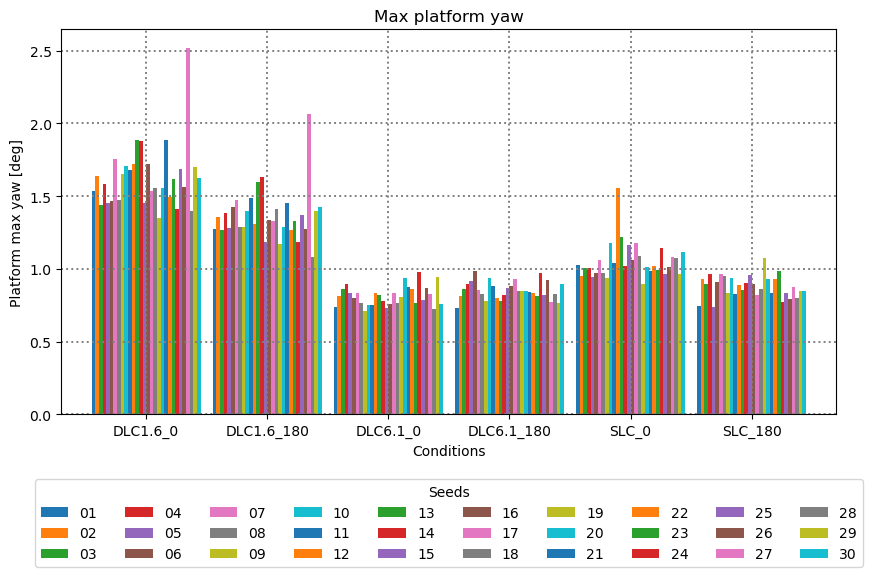

In [ ]:

valHeader = ['PtfmYaw']
valType   = 'max'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']

pivot_df = dataDf1.pivot(index='cond_head', columns='seed', values='PtfmYaw')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform max yaw [deg]')
plt.xticks(rotation=0)
plt.title('Max platform yaw')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")



# pivot_df['min'] = pivot_df.min(axis=1)
# pivot_df['max'] = pivot_df.max(axis=1)

# dist =  np.mean(plt.ylim()) * 0.2

# for index, row in pivot_df.iterrows():
#     x_coord = pivot_df.index.get_loc(index)  # Get the numerical x-coordinate
#     plt.annotate(f'Max: {row["max"]:.2f} m', xy=(x_coord, np.mean(plt.ylim())),
#                 ha='center', color='k', weight='bold')
#     plt.annotate(f'Min: {row["min"]:.2f} m', xy=(x_coord, np.mean(plt.ylim()) - dist),
#                 ha='center', color='k', weight='bold')
#     #difference
#     plt.annotate(f'Diff: {(row["max"]-row["min"]):.2f} m', xy=(x_coord, np.mean(plt.ylim()) - 2 * dist),
#                 ha='center', color='k', weight='bold')

# plt.show()

# print('Max platform surge [m]')
# displayDf(pivot_df, nCols = 6)

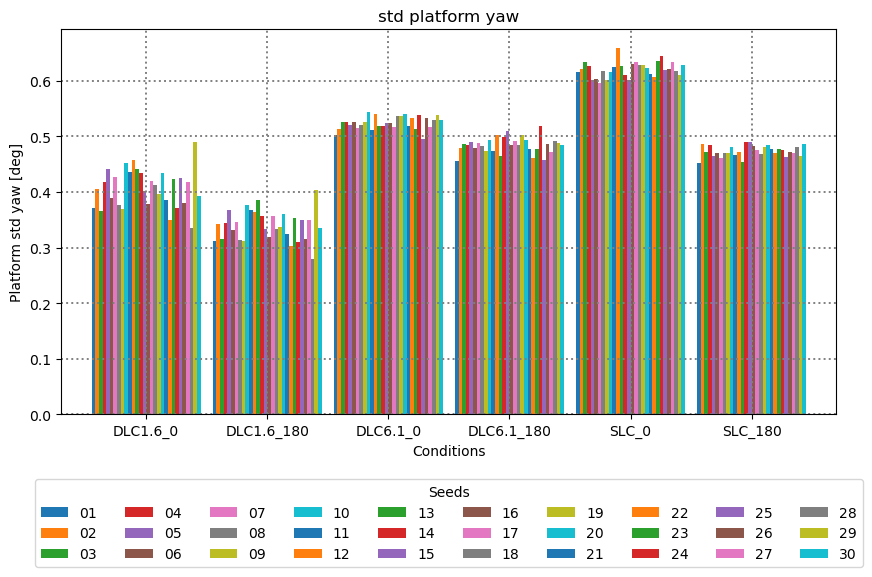

In [ ]:

valHeader = ['PtfmYaw']
valType   = 'std'
dataDf1               = sumDf.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy() #select only the mean values of FAIRTEN6 which is the upwind line
dataDf1['cond_head']  = sumDf['cond_head']
dataDf1['seed']       = sumDf['seed']

pivot_df = dataDf1.pivot(index='cond_head', columns='seed', values='PtfmYaw')


pivot_df.plot(kind='bar', figsize=(10, 5), width = 0.9)

plt.xlabel('Conditions')
plt.ylabel('Platform std yaw [deg]')
plt.xticks(rotation=0)
plt.title('std platform yaw')
plt.legend(title='Seeds', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncols=10)
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
